# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

We'll try to write some TensorFlow code to predict the price of Bitcoin based on the historical data of the Bitcoin itself.

## Get data
We're going to be using historical price data of BTC. Data has been downloaded from Yahoo Finance service.

In [1]:
# Import data with pandas
import pandas as pd

# Read in BTC data and pass the dates
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas that column 1 is datetime format

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [2]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-03,28680.494141,29259.533203,28178.388672,29006.308594,29006.308594,19122972518
2023-05-04,29031.304688,29353.185547,28694.039063,28847.710938,28847.710938,15548678514
2023-05-05,28851.480469,29668.908203,28845.509766,29534.384766,29534.384766,17936566518
2023-05-06,29538.859375,29820.126953,28468.966797,28904.623047,28904.623047,15913866714
2023-05-07,28916.708984,29151.941406,28788.570313,28897.636719,28897.636719,11557177344


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3155 entries, 2014-09-17 to 2023-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3155 non-null   float64
 1   High       3155 non-null   float64
 2   Low        3155 non-null   float64
 3   Close      3155 non-null   float64
 4   Adj Close  3155 non-null   float64
 5   Volume     3155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 172.5 KB


In [4]:
# How many samples do we have?
len(df)

3155

In [5]:
# How many years is this?
3155/365

8.643835616438356

We've collected the historical price of BTC (from past 8,5 years or so) which gave exactly 3155 samples. 

Typically deep learning models thrive when being fed lots and lots of samples (where 'lots and lots' can be millions or more). 

A smaller number of samples is something you'll often run into while working with the time series problem.

> **NOTE**: The *seasonality* of a time series dataset is referred as the number of samples per year in given series. For our BTC data, it has seasonality of *daily* or value of *365* which speaks for itself.

In [6]:
# Only leave the closing price per each day
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-03,29006.308594
2023-05-04,28847.710938
2023-05-05,29534.384766


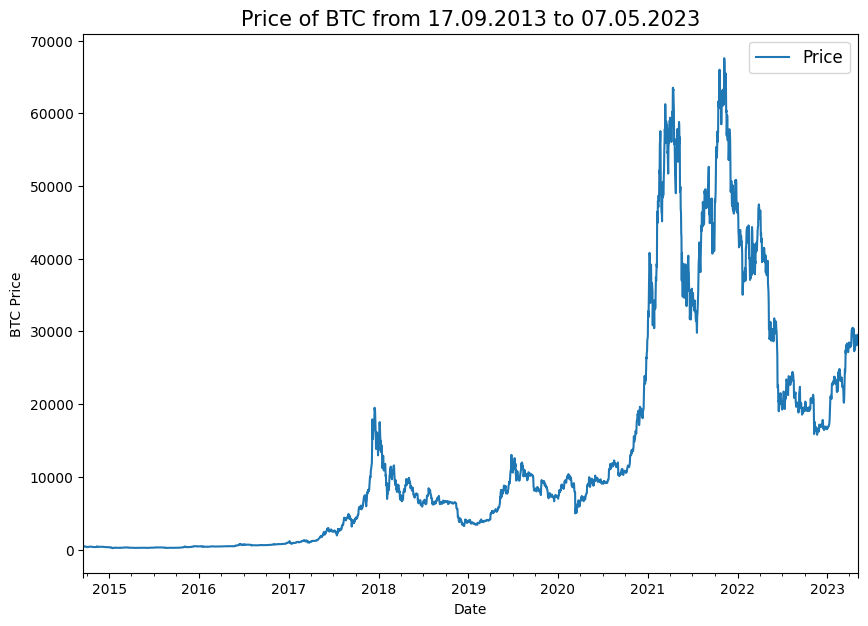

In [7]:
# Visualize the BTC price
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.title('Price of BTC from 17.09.2013 to 07.05.2023', fontsize=15)
plt.legend(fontsize=12)

## Importing time series data with Python's CSV module

In [8]:
# Importing and formatting data with Python CSV library
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv", 'r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=",")
  next(csv_reader) # goes through the iterator and ignores/skips next line - first line in our example
  
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates, not as strings
    btc_price.append(float(line[4])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Text(0, 0.5, 'BTC price')

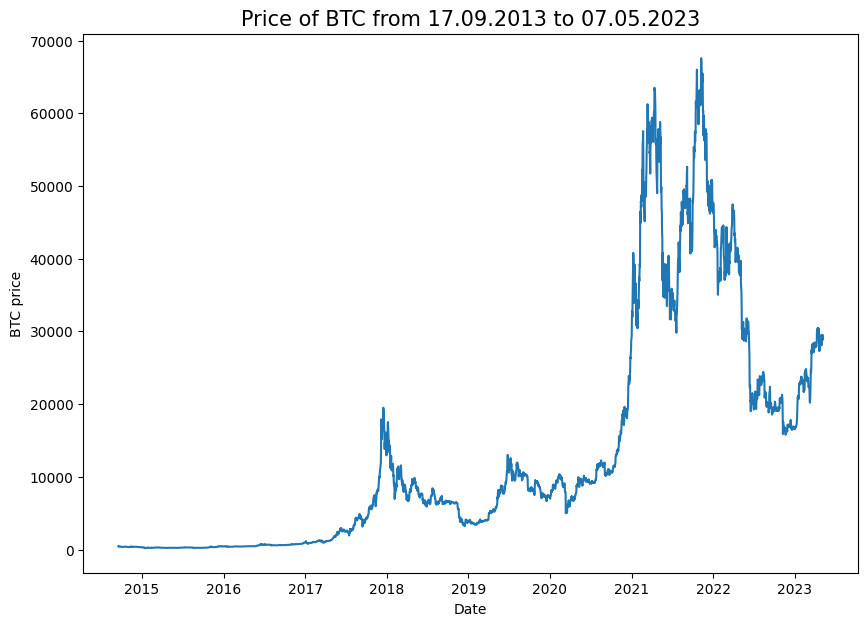

In [9]:
# Plot from Python CSV
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of BTC from 17.09.2013 to 07.05.2023", fontsize=15)
plt.xlabel("Date")
plt.ylabel("BTC price")

## Format data part 1: Create train and test sets of our times series data

### Creating training and test sets with time series data (the wrong way)

In [10]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

In [11]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2524,), (631,), (2524,), (631,))

Text(0.5, 1.0, 'Comparison of train and test datasets')

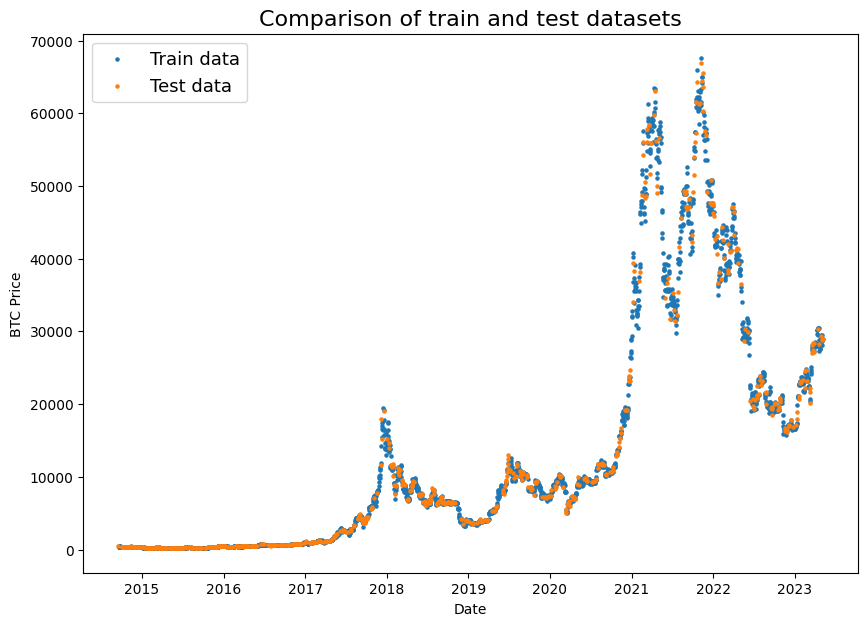

In [12]:
# Plotting wrong splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

### Create the train and test sets for time series (the proper way)

In [13]:
split_size = int(0.8 * len(prices)) # 80% test, 20% test; can be changed as needed

# Create proper splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2524, 631, 2524, 631)

Text(0.5, 1.0, 'Comparison of train and test datasets')

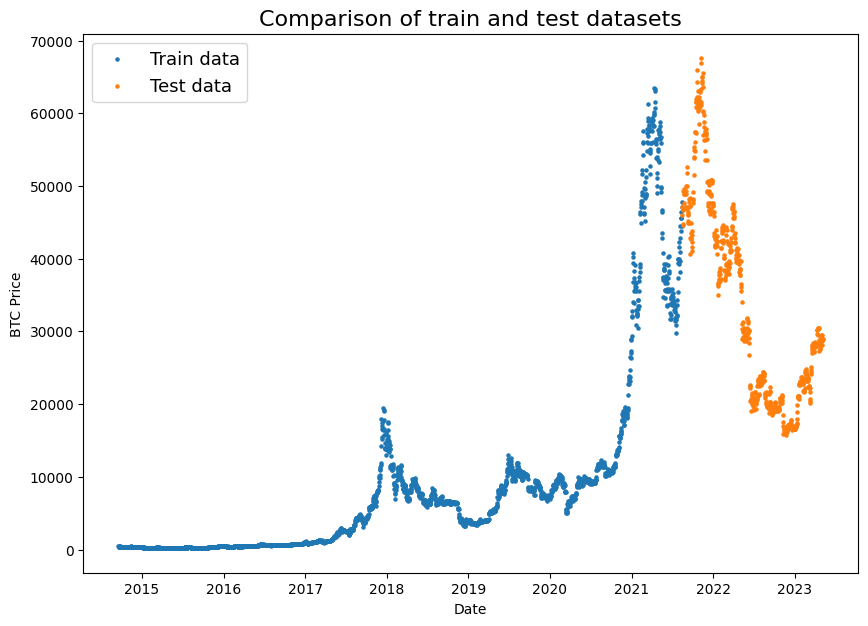

In [14]:
# Plot the correct splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

## Create a plotting function
As typing plotting code is tedious, it's time to functionize it.

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) againt values (a series of values across timesteps).

  Parameters:
  -----------
  timesteps : array of timestep values
  values : array of values across time
  format: style of plot, default "."
  start: where to start the plot (indexing from start of timesteps and values)
  end: same as above, but end
  label: label to show on plot about values, default None
  """
  # Plot the series
  #plt.figure(figsize=(10,7))
  plt.plot(timesteps[start:end],
           values[start:end],
           format,
           label=label)
  
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

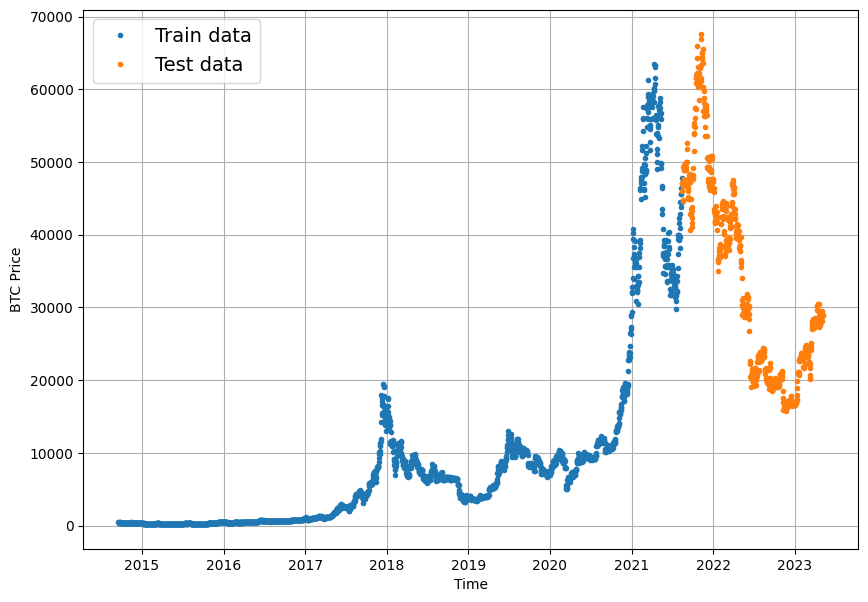

In [16]:
# Test the plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,
                 values=y_train,
                 label='Train data')
plot_time_series(timesteps=X_test,
                 values=y_test,
                 label='Test data')

## Modelling experiments

We've got some historical Bitcoin data. It's about time to note down the experiments we'd like to run.

Terms to be familiar with:
* *horizon* - steps into the future to predict
* *window size* - number of timestep to be used to predict the *horizon*

Experiments will be as follows:
0. Naive based model (baseline)
1. Dense model: horizon = 1, window = 7
2. Same as model 1: horizon = 1, window = 7
3. Same as model 1: horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Same as model 1 (but with multivariate data)
7. N_BEATS algorithm
8. Ensemble (multiple models stacked together)
9. Future prediction model
10. Same as model 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

> The prediction at timestep **t** (y-hat) is equal to the value at timestep **t-1** (previous timestep) - this is for a horizon of 1.

Lecture for this section:
https://otexts.com/fpp3/simple-methods.html

In [17]:
# Creating a naive forecast 
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([47047.003906, 46004.484375, 44695.359375, 44801.1875  ,
        46717.578125, 49339.175781, 48905.492188, 49321.652344,
        49546.148438, 47706.117188]),
 array([29473.787109, 29340.261719, 29248.488281, 29268.806641,
        28091.568359, 28680.537109, 29006.308594, 28847.710938,
        29534.384766, 28904.623047]))

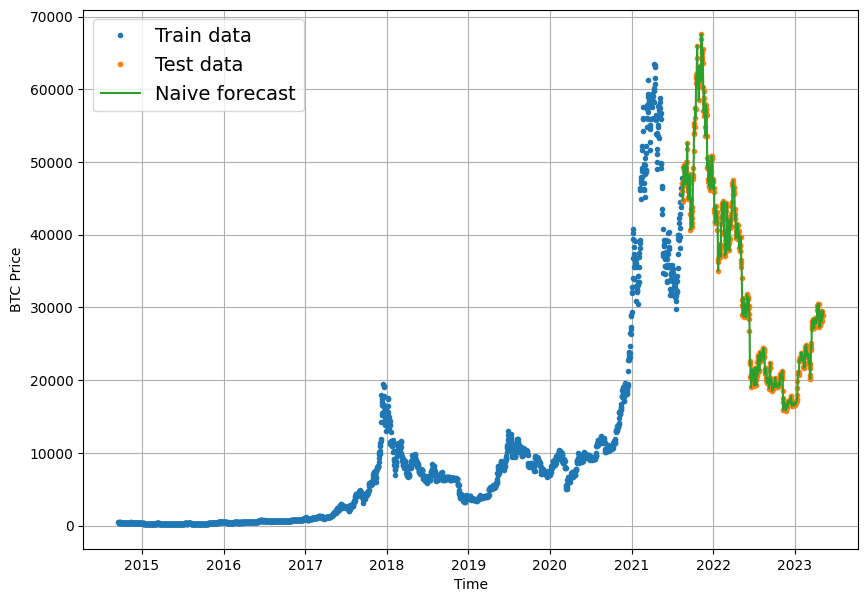

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

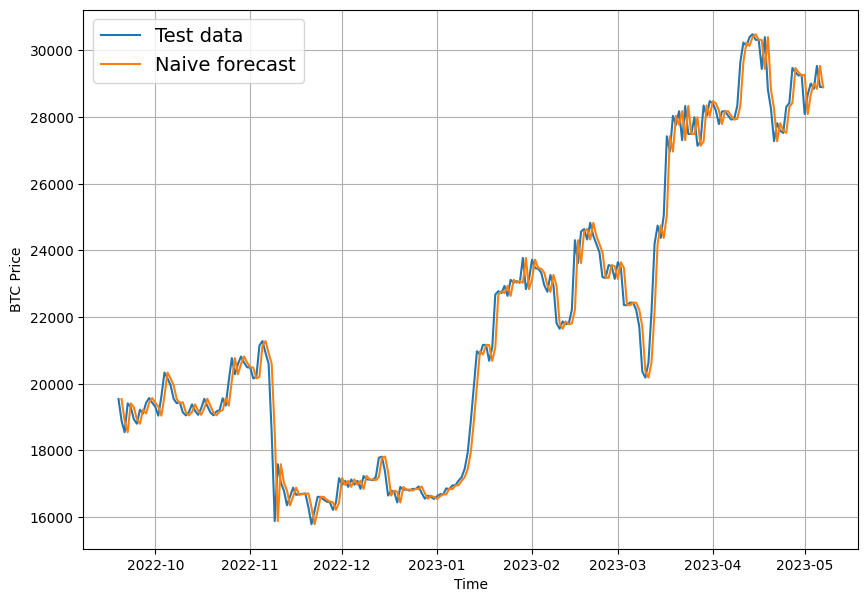

In [19]:
# Plot naive forecast - zoomed in version
plt.figure(figsize=(10, 7))
#plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=400, format='-', label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=400, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing? 

Predicting a number, so that means our problem is a **regression** problem. 

Because we're working on a regression problem, we're going to need some regression-like metrics.

A few common regression metrics, which also can be use for time series forecasting, are:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean sqaured error
* MAPE (sMAPE)- (scaled) mean absolute percentage error
* MASE - mean absolute scaled error

Main thing we're evaluating here is: **how do our model's forecast (`y_pred`) compare agains the actual values (`y_true`).**

### Creating MASE function

In [20]:
import tensorflow as tf

In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE metric (assuming no seasonality of data).
  """

  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:],
                           y_pred=naive_forecast).numpy()

1.0005690752533343

### Create a function for all of the metrics

In [23]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [24]:
# Get the Naive forecast results
naive_results = evaluate_preds(y_true=y_test[1:], 
                               y_pred=naive_forecast)
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

In [25]:
# Average, min & max price
print(f"Average price: {tf.reduce_mean(y_test):.2f} USD") 
print(f"Minimum price: {tf.reduce_min(y_test):.2f} USD") 
print(f"Maximum price: {tf.reduce_max(y_test):.2f} USD")

Average price: 32882.82 USD
Minimum price: 15787.28 USD
Maximum price: 67566.83 USD


## Other model you can use for baselines and for actual forecasts
In this notebook, the main focus is on TensorFlow and building deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with:
https://github.com/mrdbourke/tensorflow-deep-learning#-10-time-series-fundamentals-and-milestone-project-3-bitpredict--exercises

## Format data part 2: Windowing our dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [26]:
# What we want to do with our BTC data
print(f"We want to use this: {btc_price[:7]} \nto predict this: {btc_price[7]}")

We want to use this: [457.334015, 424.440002, 394.79599, 408.903992, 398.821014, 402.152008, 435.790985] 
to predict this: 423.204987


In [27]:
# Setting up global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use past 7 days to make a prediction

In [28]:
# Create a function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

  E.g.:
    if horizon = 1:
      Input = [0, 1, 2, 3, 4, 5, 6, 7]
      Output = ([0, 1, 2, 3, 4, 5, 6], [7])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data. However, it only works on a small scale.

We need the way to do the above across our entire time series...

We could do this with Python `for()` loops, however for large time series that would be quite slow.

To speed things up, we'll leverage `NumPy`'s array indexing.

The function will:
1. Create a windows step of a specific window size.
2. Use `Numpy` indexing to create 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]...]
```
3. Uses the 2D array of multiple window step to index on a target series. 
4. Uses our `get_labelled_windows()` function to turn the window steps into windows with a specifide horizon.

> **Resource**: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [30]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows
  of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (plus horizon)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window step (minus 1 to account for indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  #print(window_indexes, window_indexes.shape)

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  #print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(3148, 3148)

In [32]:
# View the first 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988]


In [33]:
# View the last 3 windows
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [29340.261719 29248.488281 29268.806641 28091.568359 28680.537109
 29006.308594 28847.710938] -> Label: [29534.384766]
Window: [29248.488281 29268.806641 28091.568359 28680.537109 29006.308594
 28847.710938 29534.384766] -> Label: [28904.623047]
Window: [29268.806641 28091.568359 28680.537109 29006.308594 28847.710938
 29534.384766 28904.623047] -> Label: [28897.636719]


> **NOTE**: There's a function that does similar to the above in `tf.keras.preprocessing`. You can try to replicate the above using said function.

Resource: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [34]:
# Another approach - data not separated as for window and horizon
sequence = tf.keras.utils.timeseries_dataset_from_array(data=prices,
                                                        targets=None,
                                                        sequence_length=8,
                                                        sequence_stride=1,
                                                        sampling_rate=1,
                                                        batch_size=32)

for batch in sequence:
  print(batch)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  587.801025 592.103027]
 [578.289001 575.04303  587.778015 592.690002 591.054016 587.801025
  592.103027 589.119995]
 [575.04303  587.778015 592.690002 591.054016 587.801025 592.103027
  589.119995 587.559021]
 [587.778015 592.690002 591.054016 587.801025 592.103027 589.119995
  587.559021 585.588013]
 [592.690002 591.054016 587.801025 592.103027 589.119995 587.559021
  585.588013 570.473022]
 [591.054016 587.801025 592.103027 589.119995 587.559021 585.588013
  570.473022 567.23999 ]
 [587.801025 592.103027 589.119995 587.559021 585.588013 570.473022
  567.23999  577.439026]
 [592.103027 589.119995 587.559021 585.588013 570.473022 567.23999
  577.439026 573.216003]
 [589.119995 587.559021 585.588013 570.473022 567.23999  577.439026
  573.216003 574.317993]
 [587.559021 585.588013 570.473022 567.23999  577.439026 573.216003
  574.317993 575.630005]
 [585.588013 570.473022 567.23999  577.439026 573.216003 574.317993
  575.

In [35]:
# Another approach pt.2 - data separated as for window and horizon
input_data = prices[:-6]
targets = prices[7:]

sequence = tf.keras.utils.timeseries_dataset_from_array(data=input_data,
                                                        targets=targets,
                                                        sampling_rate=1,
                                                        sequence_length=7,
                                                        sequence_stride=1,
                                                        batch_size=32)


for batch in sequence:
  inputs, targets = batch
  #assert np.array_equal(inputs[0], prices[:7])
  #assert np.array_equal(targets[0], prices[7])
  #break
  print(inputs[1], targets[1])
print(prices[-10:])

tf.Tensor(
[424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987], shape=(7,), dtype=float64) tf.Tensor(411.574005, shape=(), dtype=float64)
tf.Tensor(
[382.845001 386.475006 383.15799  358.416992 358.345001 347.270996
 354.70401 ], shape=(7,), dtype=float64) tf.Tensor(352.989014, shape=(), dtype=float64)
tf.Tensor(
[350.847992 352.920013 367.572998 376.901001 375.347992 368.369995
 369.670013], shape=(7,), dtype=float64) tf.Tensor(376.446991, shape=(), dtype=float64)
tf.Tensor(
[334.571991 322.533997 319.007996 327.924011 315.863007 317.239014
 312.670013], shape=(7,), dtype=float64) tf.Tensor(310.737, shape=(), dtype=float64)
tf.Tensor(
[247.847    253.718002 273.472992 263.475006 233.914993 233.513
 226.425003], shape=(7,), dtype=float64) tf.Tensor(217.464005, shape=(), dtype=float64)
tf.Tensor(
[237.470001 236.425995 253.828003 254.263    260.201996 275.670013
 281.701996], shape=(7,), dtype=float64) tf.Tensor(273.09201, shape=(), dtype=float64)
tf.Tensor(


## Turning windows into training and test datasets

In [36]:
# Make the splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into test and train
  datasets.
  """
  split_size = int(len(windows) * (1 - test_split)) # default to 80% train / 20% test

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [37]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

In [38]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

In [39]:
# Chech to see if the train labels are the same (before and after the split)
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate, `ModelCheckpoint` is quite useful. This way we can compare apples to apples.

More specifically, we want to compare each of our model's best perfoemance against the other model's best performance.

For example, if our model performs best on epoch 55, but the training is for 100 epochs, we'd like to load and evaluate the model on the best epoch there was.


In [40]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=1,
                                            save_best_only=True,
                                            monitor='val_loss')

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 units and ReLU activation funciton
* An output layer with a linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size = 128 (previously we've used 32)
* Epochs = 100

Why these values? They were picked out of experimenation.

* **Hyperparameters** = values a machine learning practitioner can adjust themselves.
* **Parameters** = values a model learns on its own.

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

# Set the random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear') # linear = no activation
], name='model_1_dense') # model name so we can save it

# 2. Compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# 3. Fit the model
history_model_1 = model_1.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              #batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
73/79 [==========================>...] - ETA: 0s - loss: 1228.7122 - mae: 1228.7122 - mse: 14964322.0000
Epoch 1: val_loss improved from inf to 1706.40100, saving model to model_experiments/model_1_dense


79/79 [==============================] - 8s 13ms/step - loss: 1180.9481 - mae: 1180.9481 - mse: 13994223.0000 - val_loss: 1706.4010 - val_mae: 1706.4010 - val_mse: 5258558.0000
Epoch 2/100
75/79 [===========================>..] - ETA: 0s - loss: 389.5701 - mae: 389.5701 - mse: 827206.9375
Epoch 2: val_loss improved from 1706.40100 to 1579.66504, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 385.0135 - mae: 385.0135 - mse: 805658.5625 - val_loss: 1579.6650 - val_mae: 1579.6650 - val_mse: 4359165.5000
Epoch 3/100
65/79 [=======================>......] - ETA: 0s - loss: 335.0519 - mae: 335.0519 - mse: 646407.3750
Epoch 3: val_loss improved from 1579.66504 to 940.66083, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 328.3675 - mae: 328.3675 - mse: 612990.1875 - val_loss: 940.6608 - val_mae: 940.6608 - val_mse: 1971650.5000
Epoch 4/100
75/79 [===========================>..] - ETA: 0s - loss: 335.1795 - mae: 335.1795 - mse: 634737.0000
Epoch 4: val_loss did not improve from 940.66083
79/79 [==============================] - 0s 4ms/step - loss: 335.0855 - mae: 335.0855 - mse: 630416.5000 - val_loss: 963.5373 - val_mae: 963.5373 - val_mse: 1946112.3750
Epoch 5/100
71/79 [=========================>....] - ETA: 0s - loss: 319.5495 - mae: 319.5495 - mse: 598253.4375
Epoch 5: val_loss did not improve from 940.66083
79/79 [==============================] - 0s 4ms/step - loss: 317.8401 - mae: 317.8401 - mse: 591552.2500 - val_loss: 1053.1429 - val_mae: 1053.1429 - val_mse: 2287694.7500
Epoch 6/100
75/79 [===========================>..] - ETA: 0s - loss: 379.3755 - mae: 379.3755 - mse: 771038.7500
Epoch 6: val_loss improved from 940.66083 to 891.5

79/79 [==============================] - 1s 9ms/step - loss: 374.4406 - mae: 374.4406 - mse: 749338.8750 - val_loss: 891.5978 - val_mae: 891.5978 - val_mse: 1805080.0000
Epoch 7/100
72/79 [==========================>...] - ETA: 0s - loss: 323.8033 - mae: 323.8033 - mse: 589918.4375
Epoch 7: val_loss did not improve from 891.59784
79/79 [==============================] - 0s 4ms/step - loss: 320.4276 - mae: 320.4276 - mse: 572564.3125 - val_loss: 1120.0890 - val_mae: 1120.0890 - val_mse: 2481475.7500
Epoch 8/100
76/79 [===========================>..] - ETA: 0s - loss: 307.3385 - mae: 307.3385 - mse: 539334.8125
Epoch 8: val_loss did not improve from 891.59784
79/79 [==============================] - 0s 4ms/step - loss: 304.4405 - mae: 304.4405 - mse: 530325.6875 - val_loss: 1236.0342 - val_mae: 1236.0342 - val_mse: 2863491.7500
Epoch 9/100
73/79 [==========================>...] - ETA: 0s - loss: 354.3373 - mae: 354.3373 - mse: 630378.2500
Epoch 9: val_loss improved from 891.59784 to 877.

79/79 [==============================] - 1s 9ms/step - loss: 346.8727 - mae: 346.8727 - mse: 613391.3125 - val_loss: 877.1214 - val_mae: 877.1214 - val_mse: 1691012.6250
Epoch 10/100
65/79 [=======================>......] - ETA: 0s - loss: 311.1596 - mae: 311.1596 - mse: 545472.7500
Epoch 10: val_loss improved from 877.12140 to 852.40875, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 9ms/step - loss: 311.6261 - mae: 311.6261 - mse: 547490.8750 - val_loss: 852.4088 - val_mae: 852.4088 - val_mse: 1641966.0000
Epoch 11/100
77/79 [============================>.] - ETA: 0s - loss: 307.0701 - mae: 307.0701 - mse: 531335.8750
Epoch 11: val_loss improved from 852.40875 to 849.44641, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 9ms/step - loss: 304.2866 - mae: 304.2866 - mse: 522295.2188 - val_loss: 849.4464 - val_mae: 849.4464 - val_mse: 1623041.7500
Epoch 12/100
76/79 [===========================>..] - ETA: 0s - loss: 325.8679 - mae: 325.8679 - mse: 590071.3125
Epoch 12: val_loss improved from 849.44641 to 846.76807, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 325.1913 - mae: 325.1913 - mse: 584630.1250 - val_loss: 846.7681 - val_mae: 846.7681 - val_mse: 1614536.0000
Epoch 13/100
73/79 [==========================>...] - ETA: 0s - loss: 298.1559 - mae: 298.1559 - mse: 517709.0000
Epoch 13: val_loss did not improve from 846.76807
79/79 [==============================] - 0s 4ms/step - loss: 301.9768 - mae: 301.9768 - mse: 544095.5000 - val_loss: 854.1309 - val_mae: 854.1309 - val_mse: 1675023.3750
Epoch 14/100
71/79 [=========================>....] - ETA: 0s - loss: 288.1121 - mae: 288.1121 - mse: 489960.6875
Epoch 14: val_loss did not improve from 846.76807
79/79 [==============================] - 0s 4ms/step - loss: 297.1184 - mae: 297.1184 - mse: 532878.5625 - val_loss: 933.6484 - val_mae: 933.6484 - val_mse: 1871938.5000
Epoch 15/100
73/79 [==========================>...] - ETA: 0s - loss: 291.6687 - mae: 291.6687 - mse: 513293.5938
Epoch 15: val_loss did not improve from 846.768

79/79 [==============================] - 1s 15ms/step - loss: 289.6325 - mae: 289.6325 - mse: 480382.6875 - val_loss: 812.2975 - val_mae: 812.2975 - val_mse: 1550710.5000
Epoch 19/100
74/79 [===========================>..] - ETA: 0s - loss: 292.2449 - mae: 292.2449 - mse: 516506.3125
Epoch 19: val_loss did not improve from 812.29755
79/79 [==============================] - 0s 5ms/step - loss: 296.5103 - mae: 296.5103 - mse: 521118.9062 - val_loss: 1357.2550 - val_mae: 1357.2550 - val_mse: 3220774.2500
Epoch 20/100
77/79 [============================>.] - ETA: 0s - loss: 321.3280 - mae: 321.3280 - mse: 569623.5625
Epoch 20: val_loss improved from 812.29755 to 806.26044, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 13ms/step - loss: 319.9360 - mae: 319.9360 - mse: 564418.1875 - val_loss: 806.2604 - val_mae: 806.2604 - val_mse: 1533440.6250
Epoch 21/100
73/79 [==========================>...] - ETA: 0s - loss: 282.0322 - mae: 282.0322 - mse: 490595.1875
Epoch 21: val_loss did not improve from 806.26044
79/79 [==============================] - 0s 6ms/step - loss: 287.5418 - mae: 287.5418 - mse: 501936.6562 - val_loss: 912.5287 - val_mae: 912.5287 - val_mse: 1737006.7500
Epoch 22/100
78/79 [============================>.] - ETA: 0s - loss: 306.0416 - mae: 306.0416 - mse: 537005.3125
Epoch 22: val_loss did not improve from 806.26044
79/79 [==============================] - 0s 5ms/step - loss: 305.7907 - mae: 305.7907 - mse: 534161.0625 - val_loss: 817.0668 - val_mae: 817.0668 - val_mse: 1558389.3750
Epoch 23/100
78/79 [============================>.] - ETA: 0s - loss: 286.8284 - mae: 286.8284 - mse: 481267.1875
Epoch 23: val_loss did not improve from 806.260

79/79 [==============================] - 1s 9ms/step - loss: 309.4127 - mae: 309.4127 - mse: 530414.3750 - val_loss: 790.9993 - val_mae: 790.9993 - val_mse: 1480921.5000
Epoch 32/100
75/79 [===========================>..] - ETA: 0s - loss: 272.0404 - mae: 272.0404 - mse: 464234.1875
Epoch 32: val_loss did not improve from 790.99933
79/79 [==============================] - 0s 4ms/step - loss: 274.4485 - mae: 274.4485 - mse: 465075.0312 - val_loss: 830.0148 - val_mae: 830.0148 - val_mse: 1537624.2500
Epoch 33/100
75/79 [===========================>..] - ETA: 0s - loss: 310.3901 - mae: 310.3901 - mse: 547270.2500
Epoch 33: val_loss did not improve from 790.99933
79/79 [==============================] - 0s 4ms/step - loss: 307.7990 - mae: 307.7990 - mse: 539429.2500 - val_loss: 1069.2615 - val_mae: 1069.2615 - val_mse: 2121299.2500
Epoch 34/100
74/79 [===========================>..] - ETA: 0s - loss: 306.9605 - mae: 306.9605 - mse: 555153.6875
Epoch 34: val_loss did not improve from 790.99

79/79 [==============================] - 1s 9ms/step - loss: 296.2217 - mae: 296.2217 - mse: 502082.6562 - val_loss: 785.1462 - val_mae: 785.1462 - val_mse: 1457894.0000
Epoch 46/100
74/79 [===========================>..] - ETA: 0s - loss: 281.6457 - mae: 281.6457 - mse: 489051.7188
Epoch 46: val_loss did not improve from 785.14624
79/79 [==============================] - 0s 4ms/step - loss: 276.1962 - mae: 276.1962 - mse: 470921.8750 - val_loss: 862.9681 - val_mae: 862.9681 - val_mse: 1644537.2500
Epoch 47/100
73/79 [==========================>...] - ETA: 0s - loss: 279.7561 - mae: 279.7561 - mse: 484349.6875
Epoch 47: val_loss did not improve from 785.14624
79/79 [==============================] - 0s 4ms/step - loss: 273.9655 - mae: 273.9655 - mse: 472444.5312 - val_loss: 1156.5281 - val_mae: 1156.5281 - val_mse: 2481059.0000
Epoch 48/100
72/79 [==========================>...] - ETA: 0s - loss: 270.5788 - mae: 270.5788 - mse: 450040.3750
Epoch 48: val_loss did not improve from 785.14

79/79 [==============================] - 1s 11ms/step - loss: 293.6497 - mae: 293.6497 - mse: 514950.3125 - val_loss: 779.8320 - val_mae: 779.8320 - val_mse: 1435123.2500
Epoch 62/100
79/79 [==============================] - ETA: 0s - loss: 305.5903 - mae: 305.5903 - mse: 551982.4375
Epoch 62: val_loss improved from 779.83197 to 779.13177, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 9ms/step - loss: 305.5903 - mae: 305.5903 - mse: 551982.4375 - val_loss: 779.1318 - val_mae: 779.1318 - val_mse: 1431812.3750
Epoch 63/100
74/79 [===========================>..] - ETA: 0s - loss: 268.1956 - mae: 268.1956 - mse: 456894.6562
Epoch 63: val_loss did not improve from 779.13177
79/79 [==============================] - 0s 4ms/step - loss: 273.9724 - mae: 273.9724 - mse: 465042.2500 - val_loss: 922.5264 - val_mae: 922.5264 - val_mse: 1792439.2500
Epoch 64/100
75/79 [===========================>..] - ETA: 0s - loss: 273.7365 - mae: 273.7365 - mse: 464957.7188
Epoch 64: val_loss did not improve from 779.13177
79/79 [==============================] - 0s 3ms/step - loss: 275.1638 - mae: 275.1638 - mse: 479088.5938 - val_loss: 859.0125 - val_mae: 859.0125 - val_mse: 1576419.7500
Epoch 65/100
71/79 [=========================>....] - ETA: 0s - loss: 267.0094 - mae: 267.0094 - mse: 413536.9062
Epoch 65: val_loss did not improve from 779.1317

79/79 [==============================] - 1s 9ms/step - loss: 287.5067 - mae: 287.5067 - mse: 493075.2812 - val_loss: 776.3141 - val_mae: 776.3141 - val_mse: 1421732.1250
Epoch 72/100
74/79 [===========================>..] - ETA: 0s - loss: 274.0584 - mae: 274.0584 - mse: 438693.3750
Epoch 72: val_loss did not improve from 776.31415
79/79 [==============================] - 0s 4ms/step - loss: 279.1948 - mae: 279.1948 - mse: 457465.1250 - val_loss: 881.5322 - val_mae: 881.5322 - val_mse: 1620620.3750
Epoch 73/100
72/79 [==========================>...] - ETA: 0s - loss: 285.9981 - mae: 285.9981 - mse: 490751.0625
Epoch 73: val_loss did not improve from 776.31415
79/79 [==============================] - 0s 4ms/step - loss: 282.6494 - mae: 282.6494 - mse: 473302.9688 - val_loss: 778.4241 - val_mae: 778.4241 - val_mse: 1422803.5000
Epoch 74/100
77/79 [============================>.] - ETA: 0s - loss: 276.6600 - mae: 276.6600 - mse: 468267.5312
Epoch 74: val_loss did not improve from 776.3141

In [42]:
# Evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 877.6041 - mae: 877.6041 - mse: 1608258.7500


[877.6040649414062, 877.6040649414062, 1608258.75]

In [43]:
# Load in the saved, best performat model
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 776.3141 - mae: 776.3141 - mse: 1421732.1250


[776.3141479492188, 776.3141479492188, 1421732.125]

### Make forecasts with a model (on the test dataset)

To make 'forecasts' on the test dataset, let's write a function to:
1. Takes in a trained model
2. Takes in some input data
3. Passes the input to the `predict()` method
4. Returns the predictions

In [44]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # 1D array of preds as output

In [45]:
# Make predictions using model_1
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10], len(model_1_preds)

20/20 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([46973.055, 46080.727, 44593.406, 44691.094, 46265.492, 48961.76 ,
        49015.082, 49229.88 , 49444.242, 47848.87 ], dtype=float32)>,
 630)

In [46]:
# Shapes had to be changes 
test_labels.shape, model_1_preds.shape

((630, 1), TensorShape([630]))

In [47]:
# Evaluate our preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 776.3141,
 'mse': 1421731.9,
 'rmse': 1192.364,
 'mape': 2.2889109,
 'mase': 1.0116225}

In [48]:
# Naive results
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

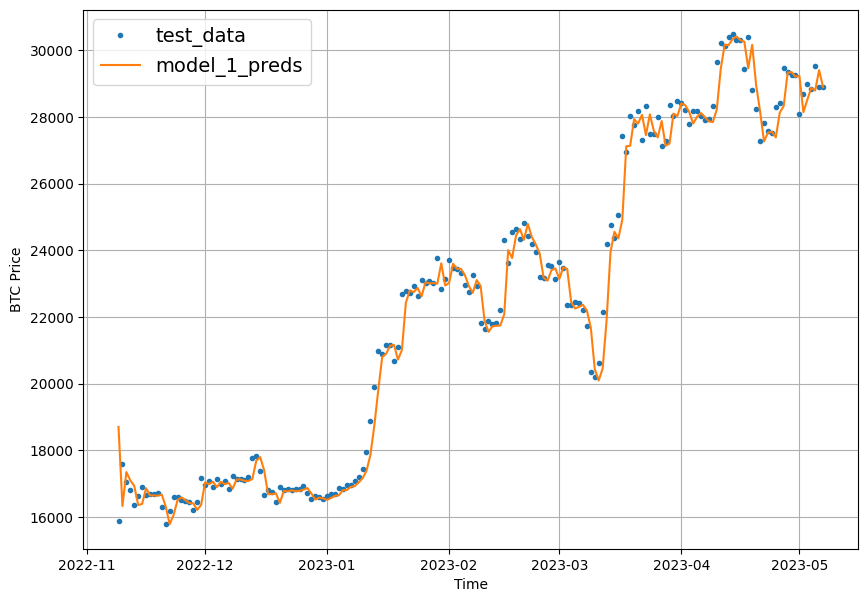

In [49]:
# Let's plot model_1 predictions 
offset=450
plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds, 
                 format="-",
                 start=offset, 
                 label='model_1_preds')

## Model 2: Dense (window = 30, horizon = 1)

In [50]:
# Update global variables
HORIZON = 1
WINDOW_SIZE = 30

In [51]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3125, 3125)

In [52]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2500, 625, 2500, 625)

In [53]:
train_windows[:3], train_labels[:3]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005, 404.424988, 399.519989, 377.181   ,
         375.46701 , 386.944   ,

In [54]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

# Compile the model
model_2.compile(loss='mae',
                optimizer='adam',
                metrics=['mse', 'mae'])

# Fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


Epoch 1: val_loss improved from inf to 3368.04370, saving model to model_experiments/model_2_dense



Epoch 2: val_loss improved from 3368.04370 to 2179.78271, saving model to model_experiments/model_2_dense



Epoch 3: val_loss did not improve from 2179.78271

Epoch 4: val_loss improved from 2179.78271 to 2011.43823, saving model to model_experiments/model_2_dense



Epoch 5: val_loss did not improve from 2011.43823

Epoch 6: val_loss improved from 2011.43823 to 1869.75159, saving model to model_experiments/model_2_dense



Epoch 7: val_loss did not improve from 1869.75159

Epoch 8: val_loss improved from 1869.75159 to 1679.65857, saving model to model_experiments/model_2_dense



Epoch 9: val_loss did not improve from 1679.65857

Epoch 10: val_loss improved from 1679.65857 to 1474.36011, saving model to model_experiments/model_2_dense



Epoch 11: val_loss did not improve from 1474.36011

Epoch 12: val_loss did not improve from 1474.36011

Epoch 13: val_loss did not improve from 1474.36011

Epoch 14: val_loss did not improve from 1474.36011

Epoch 15: val_loss did not improve from 1474.36011

Epoch 16: val_loss improved from 1474.36011 to 1248.87524, saving model to model_experiments/model_2_dense



Epoch 17: val_loss did not improve from 1248.87524

Epoch 18: val_loss improved from 1248.87524 to 1246.23877, saving model to model_experiments/model_2_dense



Epoch 19: val_loss did not improve from 1246.23877

Epoch 20: val_loss improved from 1246.23877 to 1162.01819, saving model to model_experiments/model_2_dense



Epoch 21: val_loss did not improve from 1162.01819

Epoch 22: val_loss did not improve from 1162.01819

Epoch 23: val_loss did not improve from 1162.01819

Epoch 24: val_loss did not improve from 1162.01819

Epoch 25: val_loss did not improve from 1162.01819

Epoch 26: val_loss did not improve from 1162.01819

Epoch 27: val_loss did not improve from 1162.01819

Epoch 28: val_loss improved from 1162.01819 to 1067.93701, saving model to model_experiments/model_2_dense



Epoch 29: val_loss did not improve from 1067.93701

Epoch 30: val_loss did not improve from 1067.93701

Epoch 31: val_loss did not improve from 1067.93701

Epoch 32: val_loss did not improve from 1067.93701

Epoch 33: val_loss improved from 1067.93701 to 1045.92932, saving model to model_experiments/model_2_dense



Epoch 34: val_loss did not improve from 1045.92932

Epoch 35: val_loss did not improve from 1045.92932

Epoch 36: val_loss did not improve from 1045.92932

Epoch 37: val_loss did not improve from 1045.92932

Epoch 38: val_loss did not improve from 1045.92932

Epoch 39: val_loss improved from 1045.92932 to 992.87408, saving model to model_experiments/model_2_dense



Epoch 40: val_loss did not improve from 992.87408

Epoch 41: val_loss did not improve from 992.87408

Epoch 42: val_loss did not improve from 992.87408

Epoch 43: val_loss improved from 992.87408 to 954.04187, saving model to model_experiments/model_2_dense



Epoch 44: val_loss did not improve from 954.04187

Epoch 45: val_loss improved from 954.04187 to 944.25659, saving model to model_experiments/model_2_dense



Epoch 46: val_loss did not improve from 944.25659

Epoch 47: val_loss did not improve from 944.25659

Epoch 48: val_loss did not improve from 944.25659

Epoch 49: val_loss did not improve from 944.25659

Epoch 50: val_loss did not improve from 944.25659

Epoch 51: val_loss did not improve from 944.25659

Epoch 52: val_loss did not improve from 944.25659

Epoch 53: val_loss did not improve from 944.25659

Epoch 54: val_loss improved from 944.25659 to 926.94208, saving model to model_experiments/model_2_dense



Epoch 55: val_loss did not improve from 926.94208

Epoch 56: val_loss did not improve from 926.94208

Epoch 57: val_loss did not improve from 926.94208

Epoch 58: val_loss did not improve from 926.94208

Epoch 59: val_loss did not improve from 926.94208

Epoch 60: val_loss improved from 926.94208 to 894.14807, saving model to model_experiments/model_2_dense



Epoch 61: val_loss did not improve from 894.14807

Epoch 62: val_loss did not improve from 894.14807

Epoch 63: val_loss did not improve from 894.14807

Epoch 64: val_loss did not improve from 894.14807

Epoch 65: val_loss did not improve from 894.14807

Epoch 66: val_loss improved from 894.14807 to 886.11340, saving model to model_experiments/model_2_dense



Epoch 67: val_loss did not improve from 886.11340

Epoch 68: val_loss improved from 886.11340 to 874.71881, saving model to model_experiments/model_2_dense



Epoch 69: val_loss did not improve from 874.71881

Epoch 70: val_loss did not improve from 874.71881

Epoch 71: val_loss did not improve from 874.71881

Epoch 72: val_loss did not improve from 874.71881

Epoch 73: val_loss did not improve from 874.71881

Epoch 74: val_loss did not improve from 874.71881

Epoch 75: val_loss did not improve from 874.71881

Epoch 76: val_loss did not improve from 874.71881

Epoch 77: val_loss did not improve from 874.71881

Epoch 78: val_loss did not improve from 874.71881

Epoch 79: val_loss did not improve from 874.71881

Epoch 80: val_loss did not improve from 874.71881

Epoch 81: val_loss did not improve from 874.71881

Epoch 82: val_loss did not improve from 874.71881

Epoch 83: val_loss improved from 874.71881 to 868.28241, saving model to model_experiments/model_2_dense



Epoch 84: val_loss did not improve from 868.28241

Epoch 85: val_loss did not improve from 868.28241

Epoch 86: val_loss improved from 868.28241 to 854.99451, saving model to model_experiments/model_2_dense



Epoch 87: val_loss did not improve from 854.99451

Epoch 88: val_loss did not improve from 854.99451

Epoch 89: val_loss did not improve from 854.99451

Epoch 90: val_loss did not improve from 854.99451

Epoch 91: val_loss did not improve from 854.99451

Epoch 92: val_loss did not improve from 854.99451

Epoch 93: val_loss did not improve from 854.99451

Epoch 94: val_loss did not improve from 854.99451

Epoch 95: val_loss did not improve from 854.99451

Epoch 96: val_loss improved from 854.99451 to 847.47729, saving model to model_experiments/model_2_dense



Epoch 97: val_loss did not improve from 847.47729

Epoch 98: val_loss did not improve from 847.47729

Epoch 99: val_loss did not improve from 847.47729

Epoch 100: val_loss did not improve from 847.47729


In [55]:
# Evaluate model_2 on test data
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 859.0673 - mse: 1595945.6250 - mae: 859.0673


[859.0673217773438, 1595945.625, 859.0673217773438]

In [56]:
# Load in the best performant model_2
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 847.4774 - mse: 1587409.1250 - mae: 847.4774


[847.4774169921875, 1587409.125, 847.4774169921875]

In [57]:
# Get the forecast predicions
model_2_preds = make_preds(model_2, test_windows)

20/20 [==============================] - 0s 1ms/step


In [58]:
# Evaluate results for model_2 prediction
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 847.4773,
 'mse': 1587409.2,
 'rmse': 1259.9243,
 'mape': 2.5061774,
 'mase': 1.1102675}

In [59]:
model_1_results

{'mae': 776.3141,
 'mse': 1421731.9,
 'rmse': 1192.364,
 'mape': 2.2889109,
 'mase': 1.0116225}

In [60]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

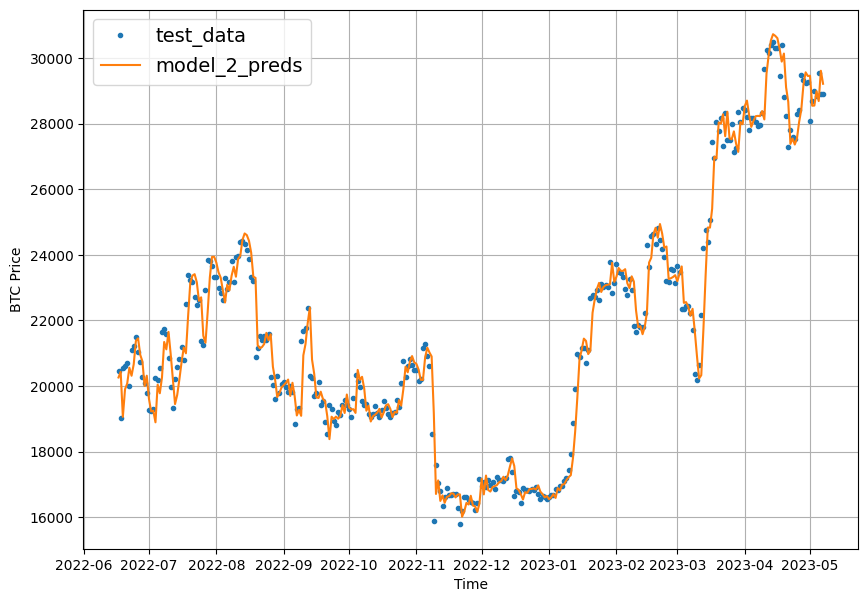

In [61]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label='model_2_preds')

## Model 3: Dense (window = 30, horizon = 7)

In [62]:
# Update global variables
HORIZON = 7
WINDOW_SIZE = 30

In [63]:
# Create new windows
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3119, 3119)

In [64]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2495, 624, 2495, 624)

In [65]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile the model
model_3.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_3.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_3.name)])


Epoch 1: val_loss improved from inf to 3669.28491, saving model to model_experiments/model_3_dense



Epoch 2: val_loss improved from 3669.28491 to 2444.98755, saving model to model_experiments/model_3_dense



Epoch 3: val_loss improved from 2444.98755 to 2344.60791, saving model to model_experiments/model_3_dense



Epoch 4: val_loss improved from 2344.60791 to 2092.31323, saving model to model_experiments/model_3_dense



Epoch 5: val_loss did not improve from 2092.31323

Epoch 6: val_loss improved from 2092.31323 to 1928.98633, saving model to model_experiments/model_3_dense



Epoch 7: val_loss did not improve from 1928.98633

Epoch 8: val_loss did not improve from 1928.98633

Epoch 9: val_loss improved from 1928.98633 to 1875.52148, saving model to model_experiments/model_3_dense



Epoch 10: val_loss did not improve from 1875.52148

Epoch 11: val_loss improved from 1875.52148 to 1837.47742, saving model to model_experiments/model_3_dense



Epoch 12: val_loss improved from 1837.47742 to 1801.81628, saving model to model_experiments/model_3_dense



Epoch 13: val_loss did not improve from 1801.81628

Epoch 14: val_loss did not improve from 1801.81628

Epoch 15: val_loss did not improve from 1801.81628

Epoch 16: val_loss did not improve from 1801.81628

Epoch 17: val_loss did not improve from 1801.81628

Epoch 18: val_loss improved from 1801.81628 to 1739.43127, saving model to model_experiments/model_3_dense



Epoch 19: val_loss did not improve from 1739.43127

Epoch 20: val_loss did not improve from 1739.43127

Epoch 21: val_loss did not improve from 1739.43127

Epoch 22: val_loss did not improve from 1739.43127

Epoch 23: val_loss improved from 1739.43127 to 1734.65747, saving model to model_experiments/model_3_dense



Epoch 24: val_loss did not improve from 1734.65747

Epoch 25: val_loss did not improve from 1734.65747

Epoch 26: val_loss improved from 1734.65747 to 1650.21619, saving model to model_experiments/model_3_dense



Epoch 27: val_loss did not improve from 1650.21619

Epoch 28: val_loss did not improve from 1650.21619

Epoch 29: val_loss did not improve from 1650.21619

Epoch 30: val_loss did not improve from 1650.21619

Epoch 31: val_loss did not improve from 1650.21619

Epoch 32: val_loss did not improve from 1650.21619

Epoch 33: val_loss did not improve from 1650.21619

Epoch 34: val_loss did not improve from 1650.21619

Epoch 35: val_loss did not improve from 1650.21619

Epoch 36: val_loss did not improve from 1650.21619

Epoch 37: val_loss did not improve from 1650.21619

Epoch 38: val_loss did not improve from 1650.21619

Epoch 39: val_loss did not improve from 1650.21619

Epoch 40: val_loss did not improve from 1650.21619

Epoch 41: val_loss did not improve from 1650.21619

Epoch 42: val_loss did not improve from 1650.21619

Epoch 43: val_loss did not improve from 1650.21619

Epoch 44: val_loss did not improve from 1650.21619

Epoch 45: val_loss did not improve from 1650.21619

Epoch 46: v


Epoch 65: val_loss did not improve from 1619.58362

Epoch 66: val_loss did not improve from 1619.58362

Epoch 67: val_loss did not improve from 1619.58362

Epoch 68: val_loss did not improve from 1619.58362

Epoch 69: val_loss did not improve from 1619.58362

Epoch 70: val_loss did not improve from 1619.58362

Epoch 71: val_loss did not improve from 1619.58362

Epoch 72: val_loss improved from 1619.58362 to 1610.89197, saving model to model_experiments/model_3_dense



Epoch 73: val_loss did not improve from 1610.89197

Epoch 74: val_loss did not improve from 1610.89197

Epoch 75: val_loss did not improve from 1610.89197

Epoch 76: val_loss did not improve from 1610.89197

Epoch 77: val_loss did not improve from 1610.89197

Epoch 78: val_loss did not improve from 1610.89197

Epoch 79: val_loss did not improve from 1610.89197

Epoch 80: val_loss did not improve from 1610.89197

Epoch 81: val_loss did not improve from 1610.89197

Epoch 82: val_loss did not improve from 1610.89197

Epoch 83: val_loss did not improve from 1610.89197

Epoch 84: val_loss improved from 1610.89197 to 1607.40796, saving model to model_experiments/model_3_dense



Epoch 85: val_loss did not improve from 1607.40796

Epoch 86: val_loss did not improve from 1607.40796

Epoch 87: val_loss did not improve from 1607.40796

Epoch 88: val_loss did not improve from 1607.40796

Epoch 89: val_loss did not improve from 1607.40796

Epoch 90: val_loss did not improve from 1607.40796

Epoch 91: val_loss did not improve from 1607.40796

Epoch 92: val_loss did not improve from 1607.40796

Epoch 93: val_loss did not improve from 1607.40796

Epoch 94: val_loss did not improve from 1607.40796

Epoch 95: val_loss did not improve from 1607.40796

Epoch 96: val_loss did not improve from 1607.40796

Epoch 97: val_loss did not improve from 1607.40796

Epoch 98: val_loss did not improve from 1607.40796

Epoch 99: val_loss did not improve from 1607.40796

Epoch 100: val_loss did not improve from 1607.40796


In [66]:
# Evaluate the model
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 1656.5148 - mae: 1656.5148 - mse: 5781627.0000


[1656.5147705078125, 1656.5147705078125, 5781627.0]

In [67]:
# Evaluate the best epoch
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1607.4080 - mae: 1607.4080 - mse: 5595111.5000


[1607.407958984375, 1607.407958984375, 5595111.5]

In [68]:
# Make the predictions
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

20/20 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[47591.008, 46878.227, 47193.008, 47057.84 , 47495.125, 47929.727,
        48058.207],
       [46770.434, 46278.125, 46577.734, 46630.727, 46609.062, 46854.73 ,
        47449.207],
       [45131.43 , 44934.82 , 44852.344, 45172.168, 45898.477, 46243.164,
        45633.7  ],
       [45221.336, 45037.293, 44618.44 , 45095.5  , 46077.26 , 45982.4  ,
        45560.844],
       [46024.867, 45577.758, 45720.35 , 46090.383, 46908.297, 46915.1  ,
        46255.91 ]], dtype=float32)>

In [69]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([1512.1049 , 1894.3711 , 2733.105  , 3271.9827 , 2461.2751 ,
         968.10266, 1243.3733 , 2176.385  , 2153.7847 ,  889.32587,
         890.98663, 1108.9453 ,  592.7433 ,  619.9593 ,  940.1713 ,
        2285.4185 , 2719.068  , 2177.6997 , 2594.389  , 3159.4084 ,
        3749.3672 , 5047.7466 , 6711.435  , 3122.7651 , 1063.3427 ,
        1086.4023 , 2204.3225 , 2612.8516 , 1998.1975 , 2482.7864 ,
        2361.9895 , 2569.74   , 3200.4888 , 3373.619  , 4078.3242 ,
        4620.7686 , 1012.4855 , 2413.202  , 1366.2188 ,  875.86273,
        1610.0692 , 1984.8672 , 2814.4988 , 4240.1846 , 6070.6562 ,
        8025.1978 , 7911.2217 , 4771.2837 , 4995.753  , 5338.514  ,
        5780.8403 , 4853.259  , 1414.351  , 1430.0447 , 2202.2708 ,
        2739.5981 , 3736.736  , 2768.197  , 3663.4792 , 4447.97   ,
        4817.114  , 2057.6624 , 1712.1708 , 1586.4799 , 1587.8025 ,
        2117.6892 , 4153.1885 , 2461.996  , 1191.255  ,  805.4704 ,
         972.9235 , 1819.5245 , 1252.7366

In [70]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([624, 7]), TensorShape([625]))

### Make our `evaluate_preds()` function to work on multiple dimension input data

In [71]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Account for different sized metrics (longer horizons; we want a single value per metric)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [72]:
# Redo model_3_results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1607.4077,
 'mse': 5595113.0,
 'rmse': 1848.1637,
 'mape': 4.86098,
 'mase': 2.0950172}

In [73]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[47591.008, 46878.227, 47193.008, 47057.84 , 47495.125, 47929.727,
        48058.207],
       [46770.434, 46278.125, 46577.734, 46630.727, 46609.062, 46854.73 ,
        47449.207],
       [45131.43 , 44934.82 , 44852.344, 45172.168, 45898.477, 46243.164,
        45633.7  ],
       [45221.336, 45037.293, 44618.44 , 45095.5  , 46077.26 , 45982.4  ,
        45560.844],
       [46024.867, 45577.758, 45720.35 , 46090.383, 46908.297, 46915.1  ,
        46255.91 ]], dtype=float32)>

In [74]:
tf.reduce_mean(model_3_preds).shape

TensorShape([])

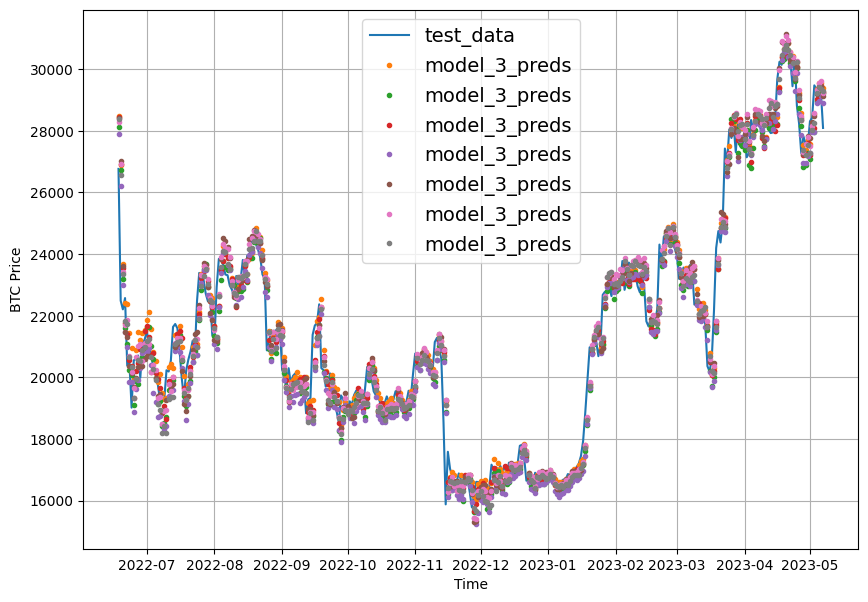

In [75]:
# Plot the model_3_preds
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 format="-",
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_3_preds,
                 start=offset,
                 label='model_3_preds')

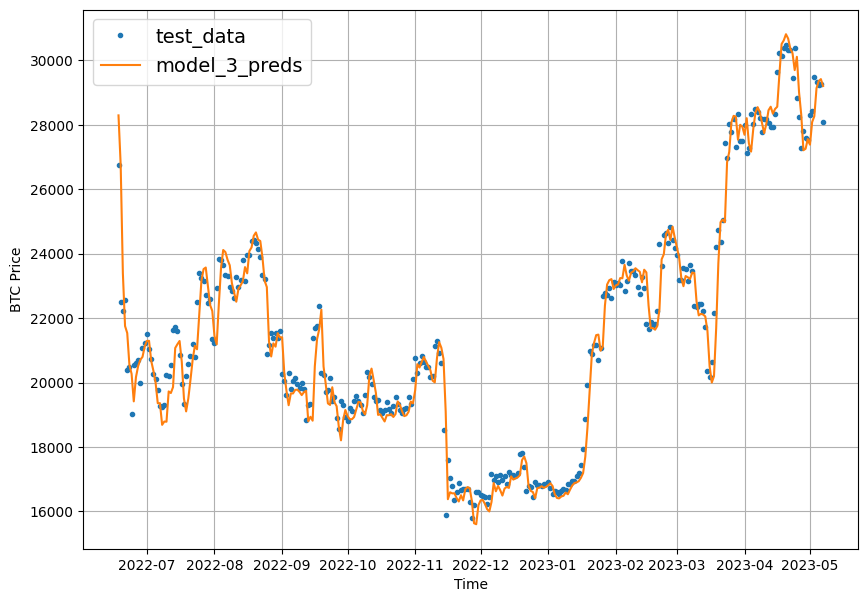

In [76]:
# Plot the model_3_preds - AGGREGATED VERSION 
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label='model_3_preds')

## Which of our models performs the best so far?

<Axes: >

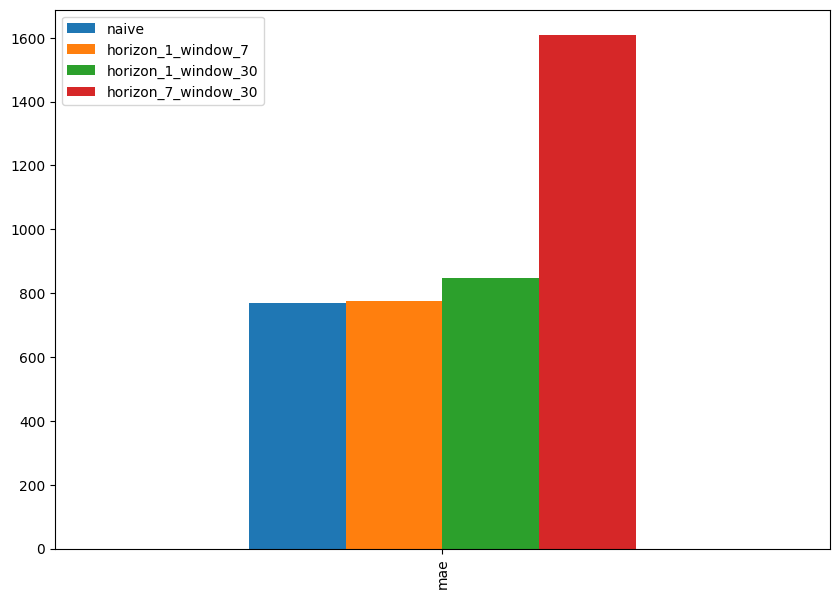

In [77]:
pd.DataFrame({'naive': naive_results['mae'],
              'horizon_1_window_7': model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']},
             index=['mae']).plot(figsize=(10,7), kind='bar')

## Model 4: Conv1D

In [78]:
HORIZON = 1 # predict next day...
WINDOW_SIZE = 7 # ...based on the week before

In [79]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(3148, 3148)

In [80]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, 
                                                                               full_labels,
                                                                               test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

To use a Conv1D input layer, we need an input shape of `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet.

In [81]:
# Check data input shape
train_windows[0].shape

(7,)

In [82]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

In [83]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for input_dim

In [84]:
# Test out the Lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}") # WINDOWS_SIZE, INPUT_DIM
print(f"Original values with expanded shape: {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: [[457.334]
 [424.44 ]
 [394.796]
 [408.904]
 [398.821]
 [402.152]
 [435.791]]


In [85]:
# Create the Conv1D model
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128,
                  kernel_size=5,
                  strides=1,
                  padding='causal',
                  activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# Compile a model
model_4.compile(loss='mae',
                optimizer='adam',
                metrics=['mae', 'mse'])

# Fit the model
model_4.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])


Epoch 1: val_loss improved from inf to 1904.66626, saving model to model_experiments/model_4_conv1D



Epoch 2: val_loss improved from 1904.66626 to 1865.85913, saving model to model_experiments/model_4_conv1D



Epoch 3: val_loss improved from 1865.85913 to 1302.65967, saving model to model_experiments/model_4_conv1D



Epoch 4: val_loss improved from 1302.65967 to 1290.46765, saving model to model_experiments/model_4_conv1D



Epoch 5: val_loss improved from 1290.46765 to 1278.55762, saving model to model_experiments/model_4_conv1D



Epoch 6: val_loss improved from 1278.55762 to 1264.04126, saving model to model_experiments/model_4_conv1D



Epoch 7: val_loss did not improve from 1264.04126

Epoch 8: val_loss did not improve from 1264.04126

Epoch 9: val_loss did not improve from 1264.04126

Epoch 10: val_loss improved from 1264.04126 to 1200.92896, saving model to model_experiments/model_4_conv1D



Epoch 11: val_loss did not improve from 1200.92896

Epoch 12: val_loss did not improve from 1200.92896

Epoch 13: val_loss improved from 1200.92896 to 1132.20422, saving model to model_experiments/model_4_conv1D



Epoch 14: val_loss did not improve from 1132.20422

Epoch 15: val_loss did not improve from 1132.20422

Epoch 16: val_loss improved from 1132.20422 to 1091.73657, saving model to model_experiments/model_4_conv1D



Epoch 17: val_loss did not improve from 1091.73657

Epoch 18: val_loss did not improve from 1091.73657

Epoch 19: val_loss improved from 1091.73657 to 1068.23792, saving model to model_experiments/model_4_conv1D



Epoch 20: val_loss did not improve from 1068.23792

Epoch 21: val_loss improved from 1068.23792 to 1006.00616, saving model to model_experiments/model_4_conv1D



Epoch 22: val_loss did not improve from 1006.00616

Epoch 23: val_loss improved from 1006.00616 to 975.05774, saving model to model_experiments/model_4_conv1D



Epoch 24: val_loss improved from 975.05774 to 963.11060, saving model to model_experiments/model_4_conv1D



Epoch 25: val_loss did not improve from 963.11060

Epoch 26: val_loss improved from 963.11060 to 956.13788, saving model to model_experiments/model_4_conv1D



Epoch 27: val_loss did not improve from 956.13788

Epoch 28: val_loss improved from 956.13788 to 947.52026, saving model to model_experiments/model_4_conv1D



Epoch 29: val_loss did not improve from 947.52026

Epoch 30: val_loss improved from 947.52026 to 933.69086, saving model to model_experiments/model_4_conv1D



Epoch 31: val_loss improved from 933.69086 to 926.37134, saving model to model_experiments/model_4_conv1D



Epoch 32: val_loss did not improve from 926.37134

Epoch 33: val_loss did not improve from 926.37134

Epoch 34: val_loss did not improve from 926.37134

Epoch 35: val_loss improved from 926.37134 to 897.34088, saving model to model_experiments/model_4_conv1D



Epoch 36: val_loss did not improve from 897.34088

Epoch 37: val_loss did not improve from 897.34088

Epoch 38: val_loss did not improve from 897.34088

Epoch 39: val_loss improved from 897.34088 to 895.71674, saving model to model_experiments/model_4_conv1D



Epoch 40: val_loss did not improve from 895.71674

Epoch 41: val_loss improved from 895.71674 to 885.63202, saving model to model_experiments/model_4_conv1D



Epoch 42: val_loss did not improve from 885.63202

Epoch 43: val_loss did not improve from 885.63202

Epoch 44: val_loss did not improve from 885.63202

Epoch 45: val_loss improved from 885.63202 to 882.88818, saving model to model_experiments/model_4_conv1D



Epoch 46: val_loss did not improve from 882.88818

Epoch 47: val_loss did not improve from 882.88818

Epoch 48: val_loss did not improve from 882.88818

Epoch 49: val_loss improved from 882.88818 to 863.55121, saving model to model_experiments/model_4_conv1D



Epoch 50: val_loss did not improve from 863.55121

Epoch 51: val_loss did not improve from 863.55121

Epoch 52: val_loss improved from 863.55121 to 857.41223, saving model to model_experiments/model_4_conv1D



Epoch 53: val_loss did not improve from 857.41223

Epoch 54: val_loss improved from 857.41223 to 854.66797, saving model to model_experiments/model_4_conv1D



Epoch 55: val_loss did not improve from 854.66797

Epoch 56: val_loss did not improve from 854.66797

Epoch 57: val_loss did not improve from 854.66797

Epoch 58: val_loss did not improve from 854.66797

Epoch 59: val_loss improved from 854.66797 to 851.75793, saving model to model_experiments/model_4_conv1D



Epoch 60: val_loss improved from 851.75793 to 843.88611, saving model to model_experiments/model_4_conv1D



Epoch 61: val_loss improved from 843.88611 to 842.99713, saving model to model_experiments/model_4_conv1D



Epoch 62: val_loss did not improve from 842.99713

Epoch 63: val_loss improved from 842.99713 to 838.30493, saving model to model_experiments/model_4_conv1D



Epoch 64: val_loss did not improve from 838.30493

Epoch 65: val_loss did not improve from 838.30493

Epoch 66: val_loss did not improve from 838.30493

Epoch 67: val_loss did not improve from 838.30493

Epoch 68: val_loss did not improve from 838.30493

Epoch 69: val_loss did not improve from 838.30493

Epoch 70: val_loss did not improve from 838.30493

Epoch 71: val_loss did not improve from 838.30493

Epoch 72: val_loss did not improve from 838.30493

Epoch 73: val_loss improved from 838.30493 to 830.82410, saving model to model_experiments/model_4_conv1D



Epoch 74: val_loss did not improve from 830.82410

Epoch 75: val_loss did not improve from 830.82410

Epoch 76: val_loss did not improve from 830.82410

Epoch 77: val_loss did not improve from 830.82410

Epoch 78: val_loss did not improve from 830.82410

Epoch 79: val_loss did not improve from 830.82410

Epoch 80: val_loss did not improve from 830.82410

Epoch 81: val_loss did not improve from 830.82410

Epoch 82: val_loss did not improve from 830.82410

Epoch 83: val_loss did not improve from 830.82410

Epoch 84: val_loss did not improve from 830.82410

Epoch 85: val_loss did not improve from 830.82410

Epoch 86: val_loss improved from 830.82410 to 812.69446, saving model to model_experiments/model_4_conv1D



Epoch 87: val_loss did not improve from 812.69446

Epoch 88: val_loss did not improve from 812.69446

Epoch 89: val_loss did not improve from 812.69446

Epoch 90: val_loss did not improve from 812.69446

Epoch 91: val_loss improved from 812.69446 to 812.13239, saving model to model_experiments/model_4_conv1D



Epoch 92: val_loss did not improve from 812.13239

Epoch 93: val_loss did not improve from 812.13239

Epoch 94: val_loss did not improve from 812.13239

Epoch 95: val_loss did not improve from 812.13239

Epoch 96: val_loss did not improve from 812.13239

Epoch 97: val_loss did not improve from 812.13239

Epoch 98: val_loss did not improve from 812.13239

Epoch 99: val_loss did not improve from 812.13239

Epoch 100: val_loss did not improve from 812.13239


In [86]:
# Evaluate model_4
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 813.6292 - mae: 813.6292 - mse: 1544976.1250


[813.6292114257812, 813.6292114257812, 1544976.125]

In [87]:
# Load in the best performing model_4
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1D')
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 812.1324 - mae: 812.1324 - mse: 1543144.7500


[812.1324462890625, 812.1324462890625, 1543144.75]

In [88]:
# Make predictions 
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47343.535, 46463.773, 45168.664, 44833.008, 46157.902, 48814.816,
       49394.543, 49605.54 , 49864.66 , 48565.414], dtype=float32)>

In [89]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 812.13245,
 'mse': 1543144.8,
 'rmse': 1242.2338,
 'mape': 2.4019432,
 'mase': 1.0582978}

In [90]:
model_1_results

{'mae': 776.3141,
 'mse': 1421731.9,
 'rmse': 1192.364,
 'mape': 2.2889109,
 'mase': 1.0116225}

## Model 5: LSTM
Let's create a RNN model for our time series data.

We're going to use the same data we have created for previous experiment.

In [91]:
# Let's create LSTM model using Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
#x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_LSTM')

# Compile
model_5.compile(loss='mae',
                optimizer='adam')
                #metrics=['mae', 'mse'])

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 7038.7910
Epoch 1: val_loss improved from inf to 20217.98242, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 5s 121ms/step - loss: 7038.7910 - val_loss: 20217.9824
Epoch 2/100
19/20 [===========================>..] - ETA: 0s - loss: 3701.5608
Epoch 2: val_loss improved from 20217.98242 to 5105.27148, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 2s 95ms/step - loss: 3634.3113 - val_loss: 5105.2715
Epoch 3/100
11/20 [===============>..............] - ETA: 0s - loss: 800.6003 
Epoch 3: val_loss improved from 5105.27148 to 1822.15637, saving model to model_experiments/model_5_LSTM
20/20 [==============================] - 2s 111ms/step - loss: 749.0929 - val_loss: 1822.1564
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 532.6348
Epoch 4: val_loss improved from 1822.15637 to 1740.14331, saving model to model_experiments

In [92]:
# Load in the best version of model_5 and evaluate
model_5 = tf.keras.models.load_model('model_experiments/model_5_LSTM')
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 818.5986


818.5986328125

In [93]:
# Make prediction 
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([47300.258, 46546.445, 45237.117, 44657.63 , 45945.09 ],
      dtype=float32)>

In [94]:
# Evaluate model_5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                y_pred=model_5_preds)
model_5_results

{'mae': 818.59863,
 'mse': 1554866.1,
 'rmse': 1246.9427,
 'mape': 2.4120045,
 'mase': 1.066724}

In [95]:
model_1_results

{'mae': 776.3141,
 'mse': 1421731.9,
 'rmse': 1192.364,
 'mape': 2.2889109,
 'mase': 1.0116225}

## Make a multivariate time series data

Before we add feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...
* day 1 - 0
* day 2 - 1
* day 3 - 0 and so on

What's a better feature to use?

Maybe Bitcon halving events?

In [96]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [97]:
# Let's add Bitcoin halving events to our data
block_reward_1 = 50 # 3 Jan 2009 - this reward isn't in our dataset (start from 17/9/2014)
block_reward_2 = 25 # 28 Nov 2012 - this reward isn't in our dataset, too
block_reward_3 = 12.5 # 9 Jul 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [98]:
# Create date ranges where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(661, 2070)

In [99]:
# Add in block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Add in block_reward values as a feature to our dataframes
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-05-03,29006.308594,6.25
2023-05-04,28847.710938,6.25
2023-05-05,29534.384766,6.25
2023-05-06,28904.623047,6.25
2023-05-07,28897.636719,6.25


<Axes: xlabel='Date'>

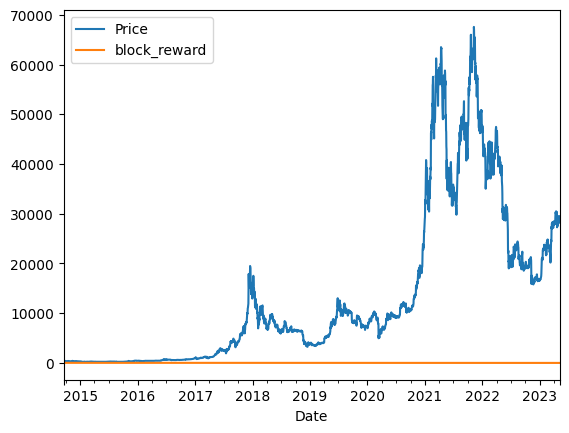

In [100]:
bitcoin_prices_block.plot()

<Axes: xlabel='Date'>

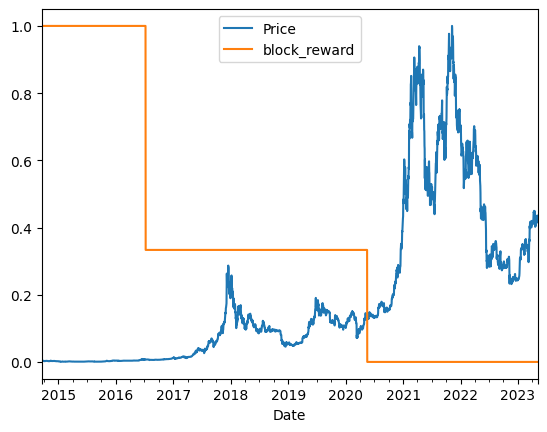

In [101]:
# Plot the block_reward vs price overtime
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot()

## Making a windowed dataset with `Pandas`
Previously we've turned our univariate time series into windowed dataset using helper functions above.

However, since we'ge got multivariate now, these functions won't work.

Not to worry, we can use the `pandas.DataFrame.shift()` method to window our multivariate data. 

In [102]:
# Setup hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [103]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): #shift values for each step in window size
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


What we've done is create a way to window our dataset directly from a `pandas.DataFrame`.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
...
```

In [104]:
# Create X (windows) and y (horizon) features
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)
X.head(), y.head()

(            block_reward     Price+1     Price+2     Price+3     Price+4  \
 Date                                                                       
 2014-09-24          25.0  435.790985  402.152008  398.821014  408.903992   
 2014-09-25          25.0  423.204987  435.790985  402.152008  398.821014   
 2014-09-26          25.0  411.574005  423.204987  435.790985  402.152008   
 2014-09-27          25.0  404.424988  411.574005  423.204987  435.790985   
 2014-09-28          25.0  399.519989  404.424988  411.574005  423.204987   
 
                Price+5     Price+6     Price+7  
 Date                                            
 2014-09-24  394.795990  424.440002  457.334015  
 2014-09-25  408.903992  394.795990  424.440002  
 2014-09-26  398.821014  408.903992  394.795990  
 2014-09-27  402.152008  398.821014  408.903992  
 2014-09-28  435.790985  402.152008  398.821014  ,
 Date
 2014-09-24    423.204987
 2014-09-25    411.574005
 2014-09-26    404.424988
 2014-09-27    399.51998

In [105]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2518, 630, 2518, 630)

In [106]:
X_train

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.00,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.00,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.00,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.00,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.00,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014
...,...,...,...,...,...,...,...,...
2021-08-11,6.25,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000,40869.554688,39747.503906
2021-08-12,6.25,45593.636719,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000,40869.554688
2021-08-13,6.25,44428.289062,45593.636719,45585.031250,46365.402344,43798.117188,44555.800781,42816.500000


## Model 6: Dense (but on multivariate data)

In [107]:
tf.random.set_seed(42)

# Make a multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_6_dense_multivariate')

# Compile the model
model_6.compile(loss='mae',
                optimizer='adam')

# Fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
19/20 [===========================>..] - ETA: 0s - loss: 2653.1084 
Epoch 1: val_loss improved from inf to 2903.10425, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 2s 41ms/step - loss: 2594.5471 - val_loss: 2903.1042
Epoch 2/100
16/20 [=======================>......] - ETA: 0s - loss: 582.8448
Epoch 2: val_loss improved from 2903.10425 to 1552.43237, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 551.8799 - val_loss: 1552.4324
Epoch 3/100
17/20 [========================>.....] - ETA: 0s - loss: 460.6943
Epoch 3: val_loss improved from 1552.43237 to 1182.72693, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 452.8806 - val_loss: 1182.7269
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 383.1514
Epoch 4: val_loss improved from 1182.72693 to 1084.46985, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 31ms/step - loss: 383.1514 - val_loss: 1084.4698
Epoch 5/100
19/20 [===========================>..] - ETA: 0s - loss: 383.4241
Epoch 5: val_loss improved from 1084.46985 to 1035.49670, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 382.4567 - val_loss: 1035.4967
Epoch 6/100
19/20 [===========================>..] - ETA: 0s - loss: 376.0305
Epoch 6: val_loss improved from 1035.49670 to 995.50128, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 31ms/step - loss: 373.7006 - val_loss: 995.5013
Epoch 7/100
17/20 [========================>.....] - ETA: 0s - loss: 350.1273
Epoch 7: val_loss improved from 995.50128 to 992.64050, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 31ms/step - loss: 343.8406 - val_loss: 992.6405
Epoch 8/100
20/20 [==============================] - ETA: 0s - loss: 318.9853
Epoch 8: val_loss improved from 992.64050 to 970.71332, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 318.9853 - val_loss: 970.7133
Epoch 9/100
15/20 [=====================>........] - ETA: 0s - loss: 336.8436
Epoch 9: val_loss did not improve from 970.71332
20/20 [==============================] - 0s 7ms/step - loss: 325.7479 - val_loss: 1005.5148
Epoch 10/100
14/20 [====================>.........] - ETA: 0s - loss: 318.9904
Epoch 10: val_loss improved from 970.71332 to 941.81836, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 47ms/step - loss: 318.8049 - val_loss: 941.8184
Epoch 11/100
11/20 [===============>..............] - ETA: 0s - loss: 331.6573
Epoch 11: val_loss improved from 941.81836 to 906.79651, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 49ms/step - loss: 321.3087 - val_loss: 906.7965
Epoch 12/100
14/20 [====================>.........] - ETA: 0s - loss: 311.3958
Epoch 12: val_loss did not improve from 906.79651
20/20 [==============================] - 0s 7ms/step - loss: 302.4314 - val_loss: 913.4048
Epoch 13/100
14/20 [====================>.........] - ETA: 0s - loss: 303.5666
Epoch 13: val_loss did not improve from 906.79651
20/20 [==============================] - 0s 7ms/step - loss: 297.8977 - val_loss: 1056.0958
Epoch 14/100
16/20 [=======================>......] - ETA: 0s - loss: 306.8613
Epoch 14: val_loss did not improve from 906.79651
20/20 [==============================] - 0s 6ms/step - loss: 312.3763 - val_loss: 1152.5844
Epoch 15/100
14/20 [====================>.........] - ETA: 0s - loss: 378.2118
Epoch 15: val_loss improved from 906.79651 to 899.27185, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 45ms/step - loss: 355.5515 - val_loss: 899.2719
Epoch 16/100
15/20 [=====================>........] - ETA: 0s - loss: 289.4973
Epoch 16: val_loss did not improve from 899.27185
20/20 [==============================] - 0s 7ms/step - loss: 294.8978 - val_loss: 933.9143
Epoch 17/100
15/20 [=====================>........] - ETA: 0s - loss: 294.6015
Epoch 17: val_loss improved from 899.27185 to 872.31476, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 35ms/step - loss: 291.6123 - val_loss: 872.3148
Epoch 18/100
20/20 [==============================] - ETA: 0s - loss: 289.6046
Epoch 18: val_loss did not improve from 872.31476
20/20 [==============================] - 0s 5ms/step - loss: 289.6046 - val_loss: 973.8994
Epoch 19/100
20/20 [==============================] - ETA: 0s - loss: 289.4005
Epoch 19: val_loss did not improve from 872.31476
20/20 [==============================] - 0s 4ms/step - loss: 289.4005 - val_loss: 1101.0173
Epoch 20/100
 1/20 [>.............................] - ETA: 0s - loss: 380.7212
Epoch 20: val_loss did not improve from 872.31476
20/20 [==============================] - 0s 4ms/step - loss: 357.5559 - val_loss: 921.5732
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 337.5712
Epoch 21: val_loss did not improve from 872.31476
20/20 [==============================] - 0s 5ms/step - loss: 337.5712 - val_loss: 876.1846
Epoch 22/100
20/20 [=======

20/20 [==============================] - 1s 51ms/step - loss: 294.7774 - val_loss: 853.9756
Epoch 24/100
20/20 [==============================] - ETA: 0s - loss: 292.5414
Epoch 24: val_loss did not improve from 853.97559
20/20 [==============================] - 0s 5ms/step - loss: 292.5414 - val_loss: 892.2458
Epoch 25/100
 1/20 [>.............................] - ETA: 0s - loss: 237.5262
Epoch 25: val_loss did not improve from 853.97559
20/20 [==============================] - 0s 5ms/step - loss: 280.6281 - val_loss: 1085.6830
Epoch 26/100
19/20 [===========================>..] - ETA: 0s - loss: 291.6504
Epoch 26: val_loss improved from 853.97559 to 846.66803, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 292.2061 - val_loss: 846.6680
Epoch 27/100
18/20 [==========================>...] - ETA: 0s - loss: 276.9267
Epoch 27: val_loss did not improve from 846.66803
20/20 [==============================] - 0s 5ms/step - loss: 285.4887 - val_loss: 942.5915
Epoch 28/100
20/20 [==============================] - ETA: 0s - loss: 279.0160
Epoch 28: val_loss did not improve from 846.66803
20/20 [==============================] - 0s 5ms/step - loss: 279.0160 - val_loss: 865.5609
Epoch 29/100
20/20 [==============================] - ETA: 0s - loss: 276.6724
Epoch 29: val_loss improved from 846.66803 to 825.28723, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 33ms/step - loss: 276.6724 - val_loss: 825.2872
Epoch 30/100
20/20 [==============================] - ETA: 0s - loss: 282.9884
Epoch 30: val_loss improved from 825.28723 to 821.53009, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 32ms/step - loss: 282.9884 - val_loss: 821.5301
Epoch 31/100
20/20 [==============================] - ETA: 0s - loss: 285.5089
Epoch 31: val_loss did not improve from 821.53009
20/20 [==============================] - 0s 5ms/step - loss: 285.5089 - val_loss: 843.7695
Epoch 32/100
17/20 [========================>.....] - ETA: 0s - loss: 279.7309
Epoch 32: val_loss did not improve from 821.53009
20/20 [==============================] - 0s 6ms/step - loss: 281.7528 - val_loss: 917.7359
Epoch 33/100
 1/20 [>.............................] - ETA: 0s - loss: 275.6093
Epoch 33: val_loss did not improve from 821.53009
20/20 [==============================] - 0s 5ms/step - loss: 279.1975 - val_loss: 875.4286
Epoch 34/100
20/20 [==============================] - ETA: 0s - loss: 320.5266
Epoch 34: val_loss did not improve from 821.53009
20/20 [==============================] - 0s 5ms/step - loss: 320.5266 - val_loss: 1236.3099
Epoch 35/100
18/20 [=======

20/20 [==============================] - 1s 33ms/step - loss: 294.0094 - val_loss: 811.8771
Epoch 39/100
20/20 [==============================] - ETA: 0s - loss: 281.5545
Epoch 39: val_loss did not improve from 811.87714
20/20 [==============================] - 0s 5ms/step - loss: 281.5545 - val_loss: 833.4799
Epoch 40/100
20/20 [==============================] - ETA: 0s - loss: 307.1639
Epoch 40: val_loss did not improve from 811.87714
20/20 [==============================] - 0s 4ms/step - loss: 307.1639 - val_loss: 929.3587
Epoch 41/100
20/20 [==============================] - ETA: 0s - loss: 273.1920
Epoch 41: val_loss improved from 811.87714 to 809.24915, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 34ms/step - loss: 273.1920 - val_loss: 809.2491
Epoch 42/100
19/20 [===========================>..] - ETA: 0s - loss: 271.6523
Epoch 42: val_loss improved from 809.24915 to 801.20441, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 32ms/step - loss: 272.8864 - val_loss: 801.2044
Epoch 43/100
19/20 [===========================>..] - ETA: 0s - loss: 273.4839
Epoch 43: val_loss improved from 801.20441 to 792.33887, saving model to model_experiments/model_6_dense_multivariate


20/20 [==============================] - 1s 31ms/step - loss: 270.8035 - val_loss: 792.3389
Epoch 44/100
 1/20 [>.............................] - ETA: 0s - loss: 295.7905
Epoch 44: val_loss did not improve from 792.33887
20/20 [==============================] - 0s 4ms/step - loss: 290.8245 - val_loss: 1087.5841
Epoch 45/100
 1/20 [>.............................] - ETA: 0s - loss: 178.7130
Epoch 45: val_loss did not improve from 792.33887
20/20 [==============================] - 0s 5ms/step - loss: 295.2592 - val_loss: 812.7471
Epoch 46/100
20/20 [==============================] - ETA: 0s - loss: 267.7796
Epoch 46: val_loss did not improve from 792.33887
20/20 [==============================] - 0s 5ms/step - loss: 267.7796 - val_loss: 866.1376
Epoch 47/100
17/20 [========================>.....] - ETA: 0s - loss: 294.4015
Epoch 47: val_loss did not improve from 792.33887
20/20 [==============================] - 0s 5ms/step - loss: 287.8933 - val_loss: 1197.4885
Epoch 48/100
16/20 [======

20/20 [==============================] - 1s 45ms/step - loss: 267.3412 - val_loss: 781.5094
Epoch 72/100
10/20 [==============>...............] - ETA: 0s - loss: 262.3392
Epoch 72: val_loss did not improve from 781.50940
20/20 [==============================] - 0s 7ms/step - loss: 275.3950 - val_loss: 898.0141
Epoch 73/100
14/20 [====================>.........] - ETA: 0s - loss: 299.3816
Epoch 73: val_loss did not improve from 781.50940
20/20 [==============================] - 0s 6ms/step - loss: 298.2577 - val_loss: 813.2646
Epoch 74/100
15/20 [=====================>........] - ETA: 0s - loss: 275.2538
Epoch 74: val_loss did not improve from 781.50940
20/20 [==============================] - 0s 7ms/step - loss: 277.1772 - val_loss: 800.1887
Epoch 75/100
15/20 [=====================>........] - ETA: 0s - loss: 273.3403
Epoch 75: val_loss did not improve from 781.50940
20/20 [==============================] - 0s 6ms/step - loss: 271.2051 - val_loss: 903.6036
Epoch 76/100
15/20 [========

20/20 [==============================] - 1s 32ms/step - loss: 280.7164 - val_loss: 779.6448
Epoch 91/100
20/20 [==============================] - ETA: 0s - loss: 295.5221
Epoch 91: val_loss did not improve from 779.64478
20/20 [==============================] - 0s 5ms/step - loss: 295.5221 - val_loss: 899.2562
Epoch 92/100
17/20 [========================>.....] - ETA: 0s - loss: 295.5487
Epoch 92: val_loss did not improve from 779.64478
20/20 [==============================] - 0s 5ms/step - loss: 304.4277 - val_loss: 793.6396
Epoch 93/100
19/20 [===========================>..] - ETA: 0s - loss: 264.6237
Epoch 93: val_loss did not improve from 779.64478
20/20 [==============================] - 0s 5ms/step - loss: 263.8967 - val_loss: 863.5359
Epoch 94/100
 1/20 [>.............................] - ETA: 0s - loss: 274.1548
Epoch 94: val_loss did not improve from 779.64478
20/20 [==============================] - 0s 4ms/step - loss: 273.6357 - val_loss: 828.6594
Epoch 95/100
19/20 [========

20/20 [==============================] - 1s 32ms/step - loss: 274.0984 - val_loss: 776.7503
Epoch 98/100
20/20 [==============================] - ETA: 0s - loss: 271.5335
Epoch 98: val_loss did not improve from 776.75031
20/20 [==============================] - 0s 4ms/step - loss: 271.5335 - val_loss: 812.9601
Epoch 99/100
20/20 [==============================] - ETA: 0s - loss: 261.3044
Epoch 99: val_loss did not improve from 776.75031
20/20 [==============================] - 0s 5ms/step - loss: 261.3044 - val_loss: 790.1318
Epoch 100/100
20/20 [==============================] - ETA: 0s - loss: 260.0763
Epoch 100: val_loss did not improve from 776.75031
20/20 [==============================] - 0s 5ms/step - loss: 260.0763 - val_loss: 819.0061


In [108]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 819.0059


819.005859375

In [109]:
# Load best performing model
model_6 = tf.keras.models.load_model('model_experiments/model_6_dense_multivariate')
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 776.7504


776.7503662109375

In [110]:
# Make predictions
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

20/20 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47113.52 , 46180.67 , 44794.93 , 44682.17 , 46396.53 , 49158.375,
       49161.105, 49452.68 , 49689.152, 47976.23 ], dtype=float32)>

In [111]:
# Evaluate predictions to get metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 776.7503,
 'mse': 1424886.8,
 'rmse': 1193.6863,
 'mape': 2.290526,
 'mase': 1.0121909}

In [112]:
model_1_results

{'mae': 776.3141,
 'mse': 1421731.9,
 'rmse': 1192.364,
 'mape': 2.2889109,
 'mase': 1.0116225}

In [113]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

## Model 7: N-BEATS algorithm
Let's now try andbuild the biggest, baddest time series forecasting model we've built so far.

More specifically, we'll be replicating the algo from the paper's figure 1:
https://arxiv.org/pdf/1905.10437.pdf

Why?
* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow subclassing to make our own custom layers
* We will get experiance using the Functional API to create custom architecture
* Potintially get state-of-the-art results and beat the Naive forecast 

### Building and testing the N-BEATS block layer

Because N-BEATS block layer does not exist in TensorFlow, we need to create it.

To create custom layers and models, we can use subclassing:
https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [114]:
# Create N-BEATS block custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__ (self, 
                input_size: int,
                theta_size: int,
                horizon: int,
                n_neurons: int,
                n_layers: int,
                **kwargs): # the keyword args argument takces care of all the parent args (input_size etc.)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 FC layers, each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs): # 'call' function is obligatory when inhereting from Layer class
    x = inputs
    for layer in self.hidden:
      x = layer(x)

    theta = self.theta_layer(x)

    # Output - backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

LEt's test our N-BEATS block class. To do so, we'll make some dummy inputs and outputs.

In [115]:
# Setup dummy N-BEATS block layer to represent inputs and outputs
tf.random.set_seed(42)

dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast and forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [116]:
# Create dummy inputs (have to be the same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE + 1), axis=0) # input shape has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [117]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are going to be activation outputs of the theta layer (random due to no training)
print(f"Backcast: \n{tf.squeeze(backcast).numpy()},\n\nForecast:\n {tf.squeeze(forecast).numpy()}")

Backcast: 
[-0.19596797  0.25996935  0.10577771 -0.73543006  0.1212547   0.07081029
  1.0778539 ],

Forecast:
 0.3137460947036743


### Preparing data for N-BEATS algorithm using `tf.data` API

To make our input data load as fast as possible, we're going to be adhearing to the performant data pipeline steps in the tf.data guide.

In [118]:
WINDOW_SIZE = 7
HORIZON = 1

In [119]:
# Create NBEATS data inputs (N-BEATS with univariate time series)
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-03,29006.308594
2023-05-04,28847.710938
2023-05-05,29534.384766


In [120]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)

bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


In [121]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Make test/train sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2518, 630, 2518, 630)

In [122]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm
The N-BEATS has a few fair number of parameters, many of them can be found in the Table 18 of the paper mentioned earlier.

In [123]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for the residual connections
Before we can craft our N-BEATS model, we need two layers for the residual connectsions - substract and add.

N-BEATS uses double residual stacking to help train its deeper architecture (section 3.2 in paper). 

In [124]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Substract
subtracted = layers.Subtract()([tensor_1, tensor_2])

# Add
added = layers.Add()([tensor_1, tensor_2])

# Results
subtracted, added

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>)

### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of `NBeatsBlock()` subclass layer (this'll be the initial block used for the network, the rest will be created as a part of stacks).
2. Create an input layer for the N-BEATS stack (we'll be using the `Keras Functional API`. 
3. Make the initial backcast and forecast for the model with the layer created in (1).
4. Use `for()` loop to create stack of block layers.
5. Use `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts.
6. Create the double residual stacking using `layers.subtract` and `layers.add`.
7. Put the model inputs and outputs together using `tf.keras.Model`.
8. Compile the model with MAE loss function (to keep it in line with previous experiments) and `Adam` optimizer with default settings as per section 5.2 of the paper.
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so long, we'll use a couple of callbacks:
  * `EarlyStopping` - because the model will fit so long, we'll stop it early if it stops improving
  * `ReduceLRonPlateau` - if a model stops improving, try lowering the learning rate to reduce the amount it improves on its weights each time (take smaller steps towards best performance)

In [125]:
%%time

tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack already created in 3.

  # 5. Use the N-BEATS block to calculate backcast and forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f'subtract_{i}')
  forecast = layers.add([forecast, block_forecast], name=f'add_{i}')

# 7. Put together inputs and outputs of our stack
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name='model_7_nbeats')

# 8. Compile model with MAE loss
model_7.compile(loss='mae',
                optimizer='adam')

# 9. Fit the model with EarlyStopping on ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            patience=100,
                                                            verbose=1)])

Epoch 1/5000
3/3 [==============================] - 54s 875ms/step - loss: 5537.8389 - val_loss: 20303.5293 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 0s 80ms/step - loss: 11514.1289 - val_loss: 22832.8242 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 0s 60ms/step - loss: 7656.4526 - val_loss: 30197.4668 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 0s 60ms/step - loss: 7511.4106 - val_loss: 24228.7578 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 0s 129ms/step - loss: 4668.8315 - val_loss: 2392.3992 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 0s 61ms/step - loss: 4058.9260 - val_loss: 39162.5234 - lr: 0.0010
Epoch 7/5000
3/3 [==============================] - 0s 63ms/step - loss: 12297.1211 - val_loss: 20625.6543 - lr: 0.0010
Epoch 8/5000
3/3 [==============================] - 0s 61ms/step - loss: 5630.7021 - val_loss: 13264.2734 - lr: 0.0010
Epoch 9/5000
3/3 [==========================

In [126]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 33ms/step - loss: 784.5019


784.5018920898438

In [127]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47195.223, 46213.887, 44768.84 , 44519.26 , 46353.645, 49083.535,
       49265.17 , 49619.35 , 49755.44 , 47948.254], dtype=float32)>

In [128]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 784.5019,
 'mse': 1440615.4,
 'rmse': 1200.2563,
 'mape': 2.3063307,
 'mase': 1.0222921}

In [129]:
model_1_results

{'mae': 776.3141,
 'mse': 1421731.9,
 'rmse': 1192.364,
 'mape': 2.2889109,
 'mase': 1.0116225}

In [130]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

### Plotting the N-BEATS architecture we've created

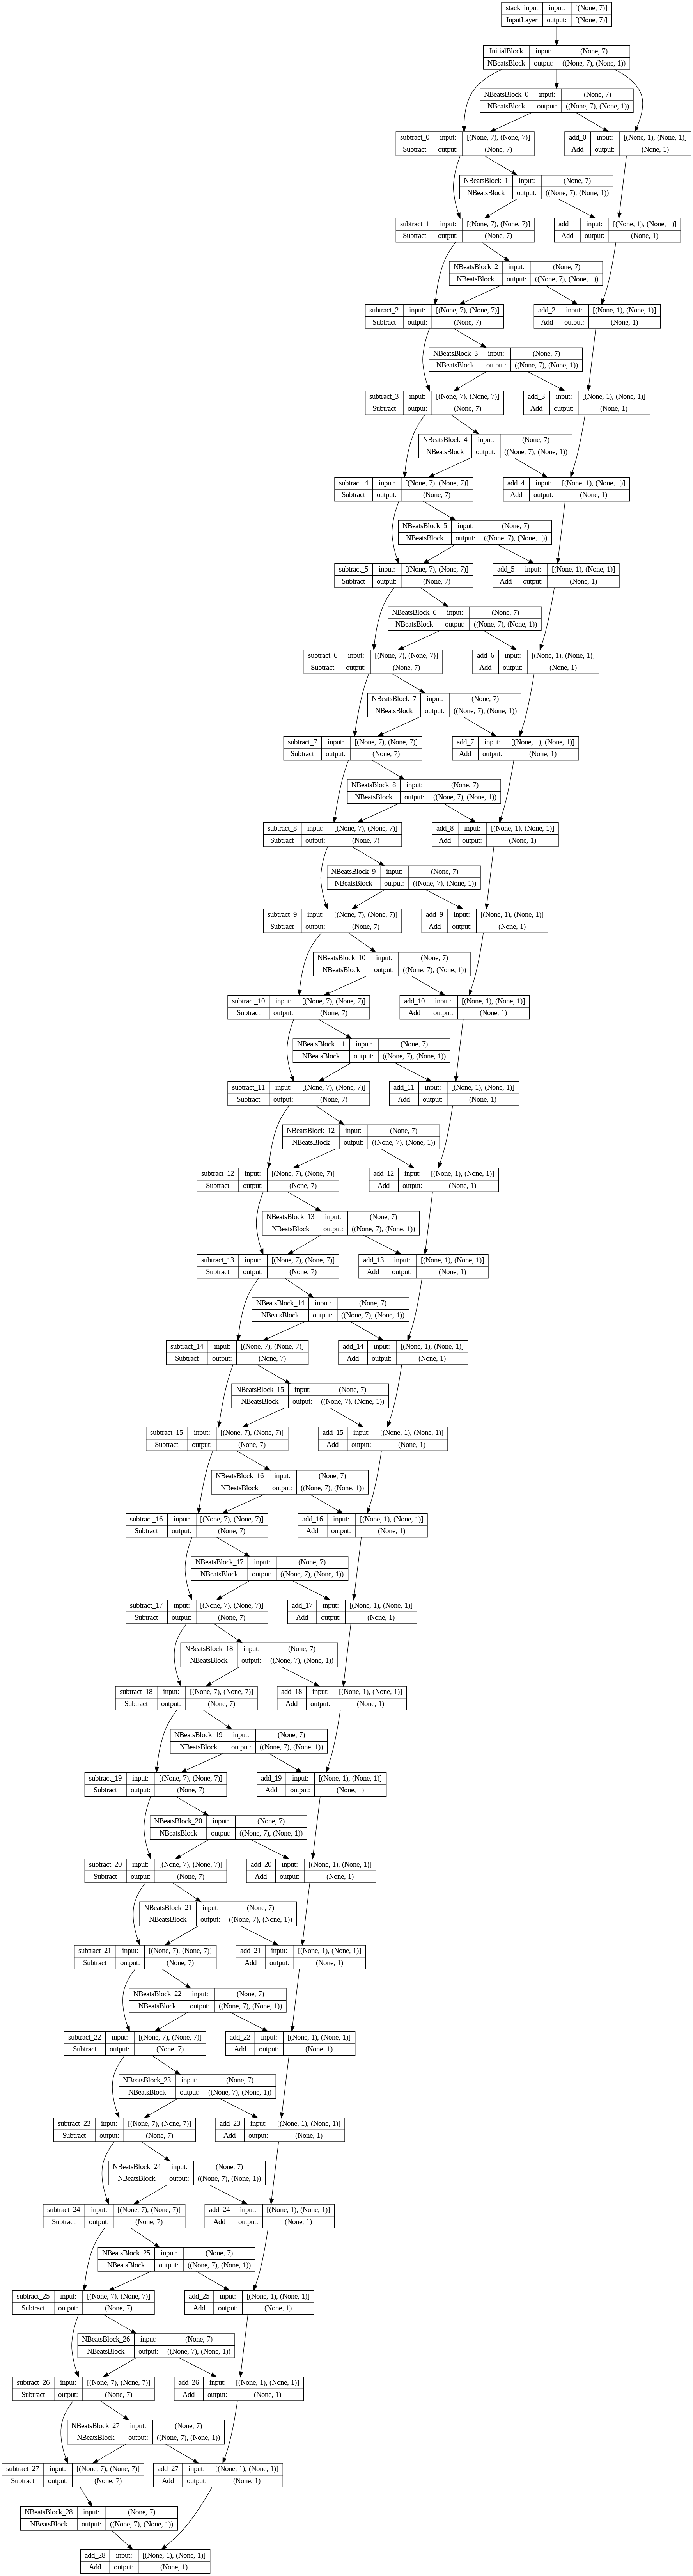

In [131]:
# Plot the N-BEATS model
tf.keras.utils.plot_model(model_7,
                          show_shapes=True,
                          show_layer_activations=True)

## Model 8: Creatin an ensemble (Stacking different models together)